In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import googlemaps

import os
from dotenv import load_dotenv
from pathlib import Path

In [2]:
dotenv_path = Path('/Users/jian/revou-nyc/revou.env')
load_dotenv(dotenv_path=dotenv_path)

key = os.getenv('googlekey')

In [3]:
gmaps_key = googlemaps.Client(key=key)

In [4]:
df = pd.read_csv  ('/Users/jian/revou-nyc/nyc-rolling-sales.csv')
df_raw = df
df

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,8409,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,...,2,0,2,2400,2575,1998,1,B9,450000,2016-11-28 00:00:00
84544,8410,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,...,2,0,2,2498,2377,1998,1,B9,550000,2017-04-21 00:00:00
84545,8411,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,...,2,0,2,4000,1496,1925,1,B2,460000,2017-07-05 00:00:00
84546,8412,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,...,0,7,7,208033,64117,2001,4,K6,11693337,2016-12-21 00:00:00


#### Get a sense of raw data

In [5]:
df['SALE PRICE'].unique()

#NULL values are written as ' -  '

array(['6625000', ' -  ', '3936272', ..., '408092', '11693337', '69300'],
      dtype=object)

In [6]:
print(f"Percentage of Missing Data in SALE PRICE: {((df['SALE PRICE'].value_counts().get(' -  ', 0)) / len(df['SALE PRICE']) * 100):.2f}%")
print(f"Percentage of Missing Data in GROSS SQUARE FEET: {((df['GROSS SQUARE FEET'].value_counts().get(' -  ', 0)) / len(df['GROSS SQUARE FEET']) * 100):.2f}%")
print(f"Percentage of Missing Data in LAND SQUARE FEET: {((df['LAND SQUARE FEET'].value_counts().get(' -  ', 0)) / len(df['LAND SQUARE FEET']) * 100):.2f}%")

Percentage of Missing Data in SALE PRICE: 17.22%
Percentage of Missing Data in GROSS SQUARE FEET: 32.66%
Percentage of Missing Data in LAND SQUARE FEET: 31.05%


In [7]:
columns_with_dash = df.columns[df.isin([' -  ']).any()].tolist()
if columns_with_dash:
    print(f"Columns with ' -  ' values: {columns_with_dash}")

Columns with ' -  ' values: ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']


In [8]:
def cleaning (df):
    # Remove uncessary columns
    df = df.drop(['Unnamed: 0'], axis=1)
    
    # Remove Duplicates
    df = df.drop_duplicates()

    # Remove duplicates without looking at SALE PRICE
    subset_columns = df.columns.difference(['Sale Price'])
    df = df.drop_duplicates(subset=subset_columns)

     # Remove uncessary columns
    df = df.drop(['BLOCK', 'LOT', 'EASE-MENT', 'APARTMENT NUMBER', 'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE'], axis=1)
    
    # Remove Sale Price where missing
    df['SALE PRICE'] = df['SALE PRICE'].replace(' -  ', np.NaN).astype(np.float64)
    df = df.dropna().reset_index(drop = True)

    # Get year, month, date as seperate entities
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    df['YEAR'] = df['SALE DATE'].apply(lambda x: x.year)
    # df['MONTH'] = df['SALE DATE'].apply(lambda x: x.month)
    # df['DAY'] = df['SALE DATE'].apply(lambda x: x.day)
    # df = df.drop(['SALE DATE'], axis=1)

    # Change Borough to Object
    number_mapping = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
    df['BOROUGH'] = df['BOROUGH'].replace(number_mapping)


    # Fill missing columns with NaN
    for col in ['GROSS SQUARE FEET', 'LAND SQUARE FEET']:
        df[col] = df[col].replace(' -  ', np.NaN).astype(np.float64)
        df[col] = df[col].astype(np.float64)
    df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].fillna(0).astype('int')
    df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(0).astype('int')
    df = df[df['LAND SQUARE FEET'] > 0]
    df = df[df['GROSS SQUARE FEET'] > 0]
    df['ZIP CODE'] = df['ZIP CODE'].astype(str)

    # Removing Year Outliers
    df = df[df['YEAR BUILT'] > 1524]
    df["BUILDING AGE"] = df["YEAR"] - df["YEAR BUILT"]
    df = df.drop(['YEAR BUILT', 'YEAR'], axis=1)

    # Move Sale Price to the first column
    df = df[['SALE PRICE'] + [col for col in df.columns if col != 'SALE PRICE']]

    # Building Group Classification
    conditions = [
    (df['BUILDING CLASS AT PRESENT'].isin(['C0','C1','C2','C3','C4','C5','C6','C7','C9','CM','D1','D2','D3','D4','D5','D6','D7','D9','L1','L3','L8','L9'])),
    (df['BUILDING CLASS AT PRESENT'].isin(['H1','H2','H3','H4','H6','H8','H9','HB','HH','HR','HS','I1','I3','I4','I5','I6','I7','I9','J1','J4','J8','K1','K2','K3','K4','K5','K6','K7','K8','K9','M1','M2','M3','M4','M9','N2','N9','O1','O2','O3','O4','O5','O6','O7','O8','O9','P2','P5','P6','P8','P9','Q8','RR','S0','S1','S2','S3','S4','S5','S9','V0','V1','W1','W2','W3','W4','W8','W9','Z0','Z9'])),
    (df['BUILDING CLASS AT PRESENT'].isin(['A0','A1','A2','A3','A4','A5','A6','A7','A9','B1','B2','B3','B9'])),
    (df['BUILDING CLASS AT PRESENT'].isin(['E1','E2','E7','E9','F1','F2','F4','F5','F9','G0','G1','G2','G4','G5','G6','G8','G9','GU','GW','Y1','Y3']))
    ]
    
    values = ['Apartments', 'Commercial Buildings', 'Housings', 'Industrial Functions']
    
    df['BUILDING GROUP'] = np.select(conditions, values, default="Apartments")

    # Finding Square Feet per Unit
    df["SQUARE FEET PER UNIT"] = df['GROSS SQUARE FEET']/df["TOTAL UNITS"]

    return df

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Unnamed: 0                      84548 non-null  int64 
 1   BOROUGH                         84548 non-null  int64 
 2   NEIGHBORHOOD                    84548 non-null  object
 3   BUILDING CLASS CATEGORY         84548 non-null  object
 4   TAX CLASS AT PRESENT            84548 non-null  object
 5   BLOCK                           84548 non-null  int64 
 6   LOT                             84548 non-null  int64 
 7   EASE-MENT                       84548 non-null  object
 8   BUILDING CLASS AT PRESENT       84548 non-null  object
 9   ADDRESS                         84548 non-null  object
 10  APARTMENT NUMBER                84548 non-null  object
 11  ZIP CODE                        84548 non-null  int64 
 12  RESIDENTIAL UNITS               84548 non-null

In [10]:
df = cleaning(df)

In [11]:
df.isna().mean()

SALE PRICE                   0.0
BOROUGH                      0.0
NEIGHBORHOOD                 0.0
BUILDING CLASS CATEGORY      0.0
BUILDING CLASS AT PRESENT    0.0
ADDRESS                      0.0
ZIP CODE                     0.0
RESIDENTIAL UNITS            0.0
COMMERCIAL UNITS             0.0
TOTAL UNITS                  0.0
LAND SQUARE FEET             0.0
GROSS SQUARE FEET            0.0
SALE DATE                    0.0
BUILDING AGE                 0.0
BUILDING GROUP               0.0
SQUARE FEET PER UNIT         0.0
dtype: float64

In [12]:
for col in df.select_dtypes('object').columns:
    print (f"{col}: {df[col].nunique()}")

BOROUGH: 5
NEIGHBORHOOD: 250
BUILDING CLASS CATEGORY: 30
BUILDING CLASS AT PRESENT: 128
ADDRESS: 34962
ZIP CODE: 180
BUILDING GROUP: 4


In [13]:
df = df[df['SALE PRICE'] > 200000]

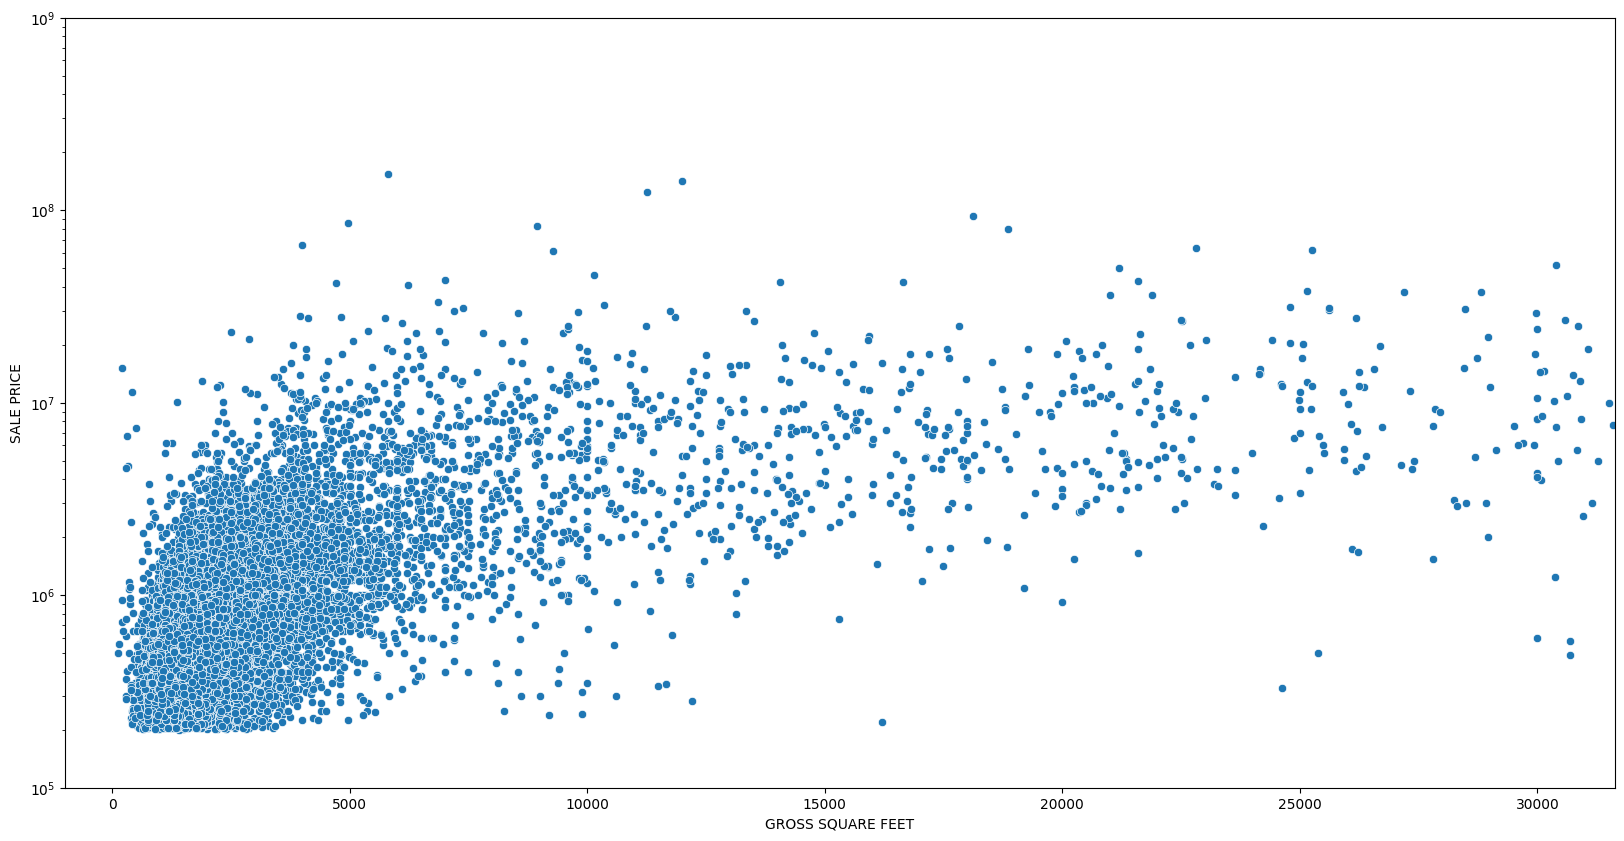

In [14]:
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(0).astype('int')

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax = plt.subplots()
sns.scatterplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df)
ax.set_xlim([-10**3, 10**4.5])
ax.set_ylim([10**5, 10**9])
ax.set_yscale("log")
plt.show()

In [15]:
heatmap_test = df[["BOROUGH", "GROSS SQUARE FEET", "BUILDING GROUP", "SALE PRICE"]]

In [16]:
print ("Correlation Between SALE PRICE AND GROSS SQUARE FEET")

for borough in df["BOROUGH"].unique():
    print (borough)
    for group in df["BUILDING GROUP"].unique():
        subset_df = df[(df["BOROUGH"] == borough) & (df["BUILDING GROUP"] == group)]
        correlation_value = subset_df["SALE PRICE"].corr(subset_df["GROSS SQUARE FEET"])
        sum = subset_df["SALE PRICE"].count()
        print(f'{group}, {sum}: {correlation_value}')
    print ("\n")

Correlation Between SALE PRICE AND GROSS SQUARE FEET
Manhattan
Apartments, 507: 0.5576893294456353
Commercial Buildings, 226: 0.8831479685693704
Housings, 136: 0.6335786777442899
Industrial Functions, 13: 0.39231878484999066


Bronx
Apartments, 793: 0.8746961187082797
Commercial Buildings, 178: 0.6997165322964529
Housings, 2157: 0.31820374769269927
Industrial Functions, 93: 0.5379990382490759


Brooklyn
Apartments, 1835: 0.5678092677192815
Commercial Buildings, 787: 0.7170914462449719
Housings, 5236: 0.5233147810649875
Industrial Functions, 160: 0.717832827261917


Queens
Apartments, 934: 0.09339545844658953
Commercial Buildings, 490: 0.8744986786333864
Housings, 8742: 0.468075358100479
Industrial Functions, 139: 0.9309864313743743


Staten Island
Apartments, 64: 0.19255869498071568
Commercial Buildings, 123: 0.18186492734009213
Housings, 4464: 0.5053639941554815
Industrial Functions, 31: 0.8407614019980234




In [17]:
print ("Correlation Between SALE PRICE AND TOTAL UNITS")

for borough in df["BOROUGH"].unique():
    print (borough)
    for group in df["BUILDING GROUP"].unique():
        subset_df = df[(df["BOROUGH"] == borough) & (df["BUILDING GROUP"] == group)]
        correlation_value = subset_df["SALE PRICE"].corr(subset_df["TOTAL UNITS"])
        sum = subset_df["SALE PRICE"].count()
        print(f'{group}, {sum}: {correlation_value}')
    print ("\n")

Correlation Between SALE PRICE AND TOTAL UNITS
Manhattan
Apartments, 507: 0.5389907784334454
Commercial Buildings, 226: 0.13496831456601555
Housings, 136: -0.29980523389997743
Industrial Functions, 13: -0.2512419534447857


Bronx
Apartments, 793: 0.8815937099185941
Commercial Buildings, 178: 0.00760981511018159
Housings, 2157: 0.016254162189382852
Industrial Functions, 93: 0.17219185464088843


Brooklyn
Apartments, 1835: 0.5947738839209497
Commercial Buildings, 787: 0.20234496924313852
Housings, 5236: 0.03924379691166787
Industrial Functions, 160: 0.07359740173201111


Queens
Apartments, 934: 0.17326534810347796
Commercial Buildings, 490: 0.0763275342463972
Housings, 8742: 0.14556522574449443
Industrial Functions, 139: 0.9125964237365979


Staten Island
Apartments, 64: 0.11249349831312531
Commercial Buildings, 123: 0.07446663378988085
Housings, 4464: 0.14899701123789535
Industrial Functions, 31: -0.11045174146926783




In [18]:
df.drop(df[(df["BUILDING GROUP"] == "Apartments") & (df["SQUARE FEET PER UNIT"] >= 1500)].index, inplace=True)

In [19]:
result = df[(df["BUILDING GROUP"] == "Apartments") & (df["BOROUGH"] == "Staten Island") & (df["TOTAL UNITS"] > 4)]["SALE PRICE"].mean()
result

1313000.0

In [20]:
df.drop(df[(df["BUILDING GROUP"] == "Apartments") & (df["BOROUGH"] == "Staten Island") & (df["TOTAL UNITS"] > 4) & (df["SALE PRICE"] < result)].index, inplace=True)

In [21]:
print ("Correlation Between SALE PRICE AND TOTAL UNITS")

for borough in df["BOROUGH"].unique():
    print (borough)
    for group in df["BUILDING GROUP"].unique():
        subset_df = df[(df["BOROUGH"] == borough) & (df["BUILDING GROUP"] == group)]
        correlation_value = subset_df["SALE PRICE"].corr(subset_df["TOTAL UNITS"])
        sum = subset_df["SALE PRICE"].count()
        print(f'{group}, {sum}: {correlation_value}')
    print ("\n")

Correlation Between SALE PRICE AND TOTAL UNITS
Manhattan
Apartments, 472: 0.55925169134273
Commercial Buildings, 226: 0.13496831456601555
Housings, 136: -0.29980523389997743
Industrial Functions, 13: -0.2512419534447857


Bronx
Apartments, 786: 0.8815961603171926
Commercial Buildings, 178: 0.00760981511018159
Housings, 2157: 0.016254162189382852
Industrial Functions, 93: 0.17219185464088843


Brooklyn
Apartments, 1789: 0.5969276745097973
Commercial Buildings, 787: 0.20234496924313852
Housings, 5236: 0.03924379691166787
Industrial Functions, 160: 0.07359740173201111


Queens
Apartments, 925: 0.628325442271799
Commercial Buildings, 490: 0.0763275342463972
Housings, 8742: 0.14556522574449443
Industrial Functions, 139: 0.9125964237365979


Staten Island
Apartments, 55: 0.7958704308399103
Commercial Buildings, 123: 0.07446663378988085
Housings, 4464: 0.14899701123789535
Industrial Functions, 31: -0.11045174146926783




In [22]:
apart_df = df[df["BUILDING GROUP"] == "Apartments"]

In [23]:
apart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4027 entries, 0 to 69147
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   SALE PRICE                 4027 non-null   float64       
 1   BOROUGH                    4027 non-null   object        
 2   NEIGHBORHOOD               4027 non-null   object        
 3   BUILDING CLASS CATEGORY    4027 non-null   object        
 4   BUILDING CLASS AT PRESENT  4027 non-null   object        
 5   ADDRESS                    4027 non-null   object        
 6   ZIP CODE                   4027 non-null   object        
 7   RESIDENTIAL UNITS          4027 non-null   int64         
 8   COMMERCIAL UNITS           4027 non-null   int64         
 9   TOTAL UNITS                4027 non-null   int64         
 10  LAND SQUARE FEET           4027 non-null   int64         
 11  GROSS SQUARE FEET          4027 non-null   int64         
 12  SALE DATE 

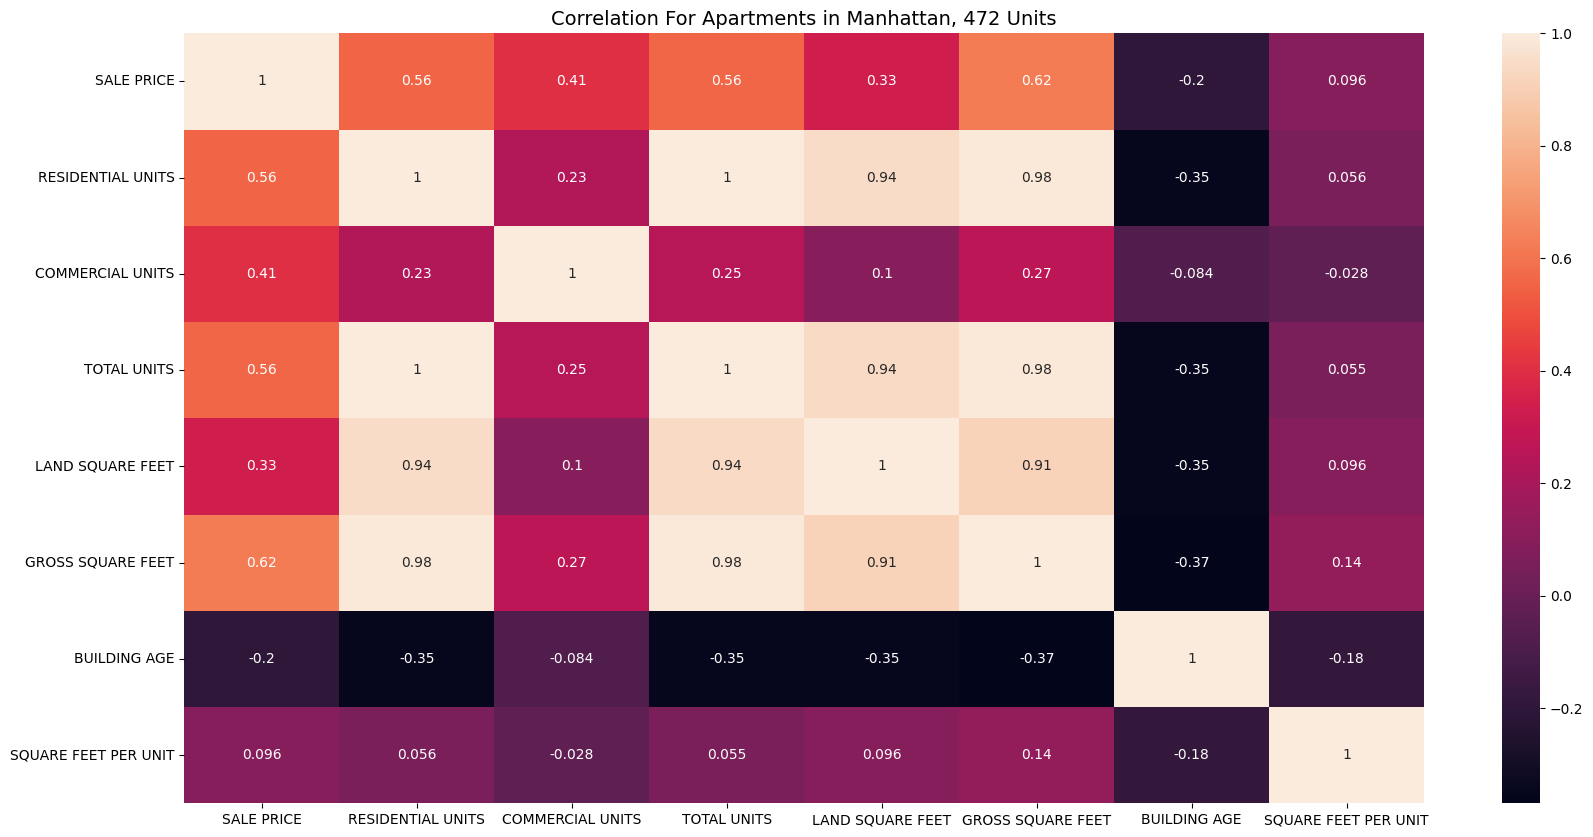

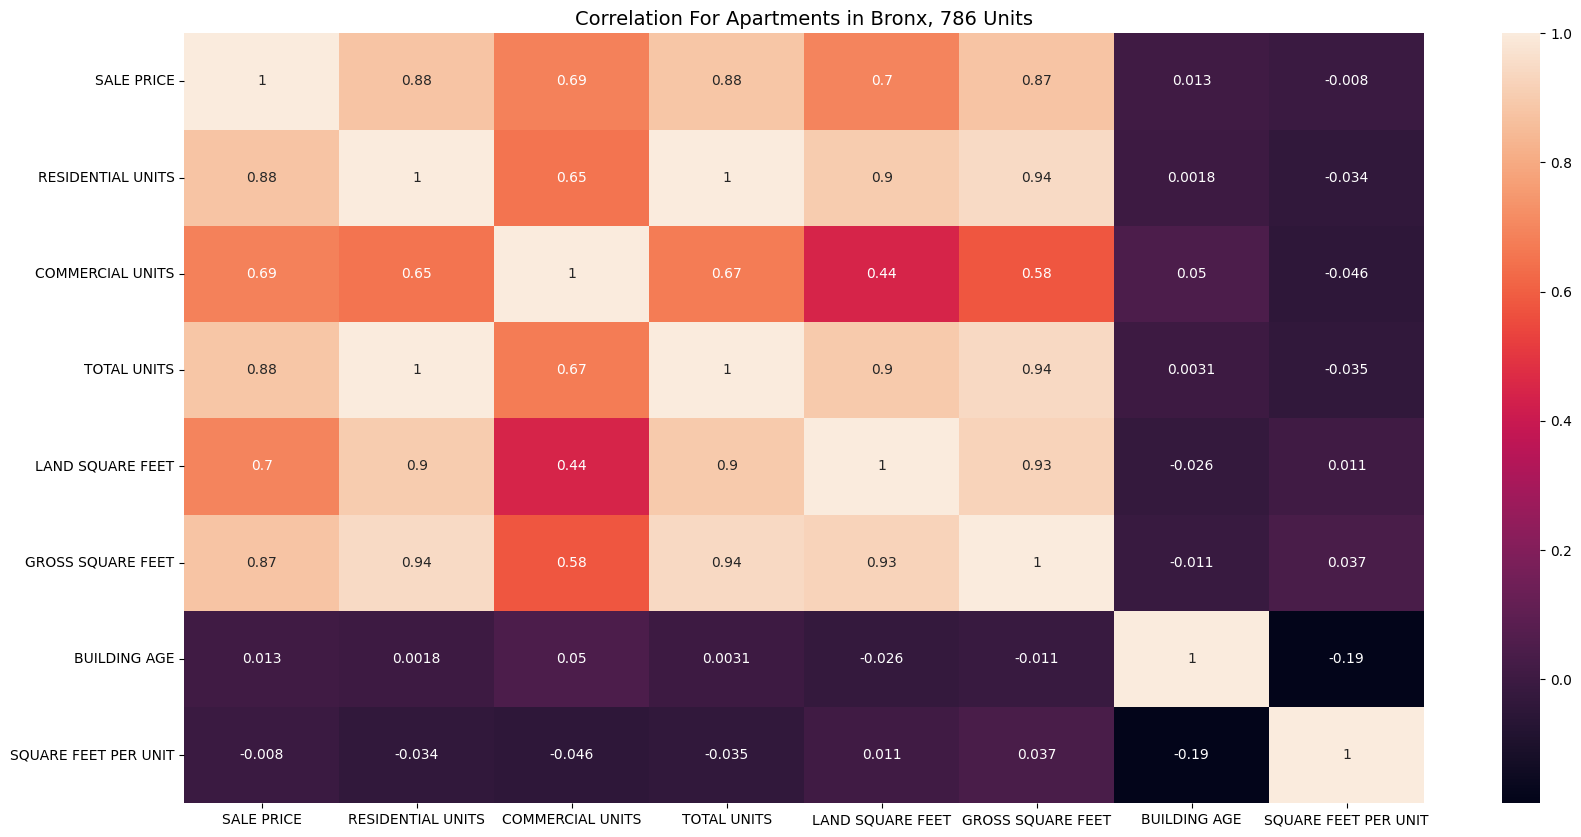

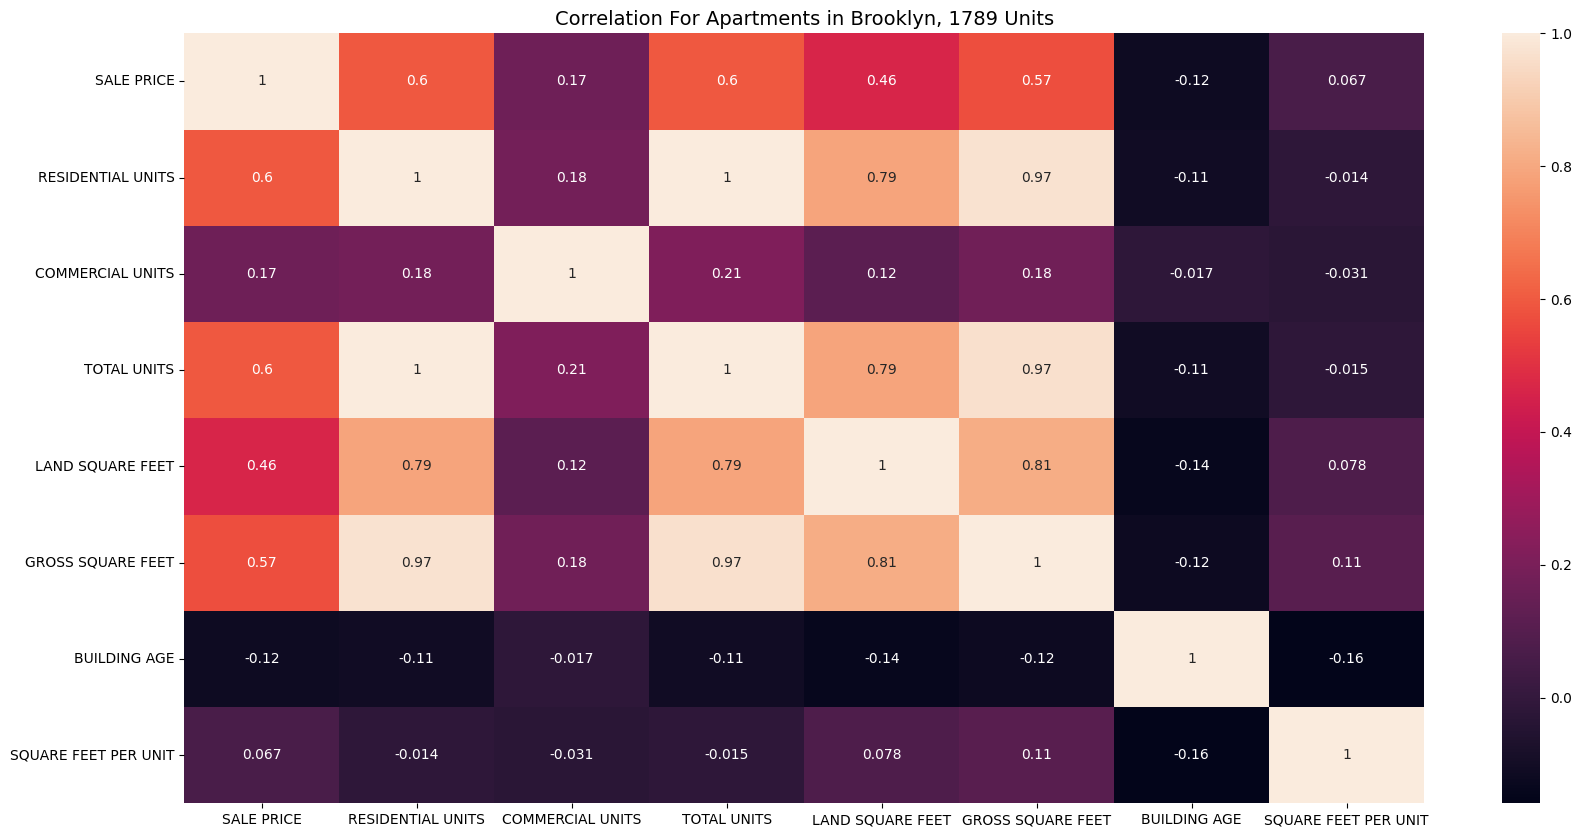

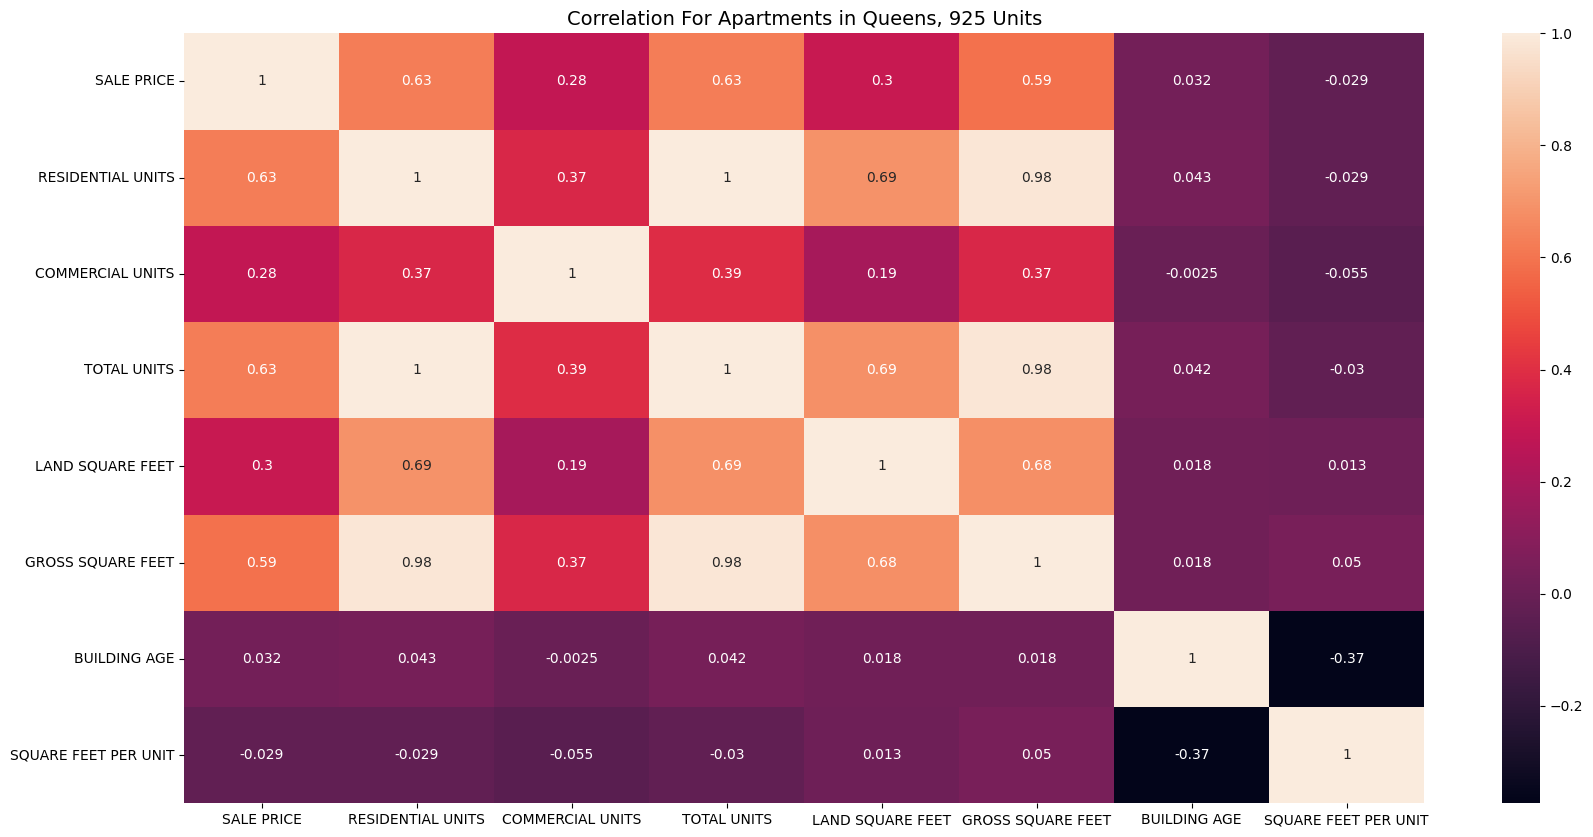

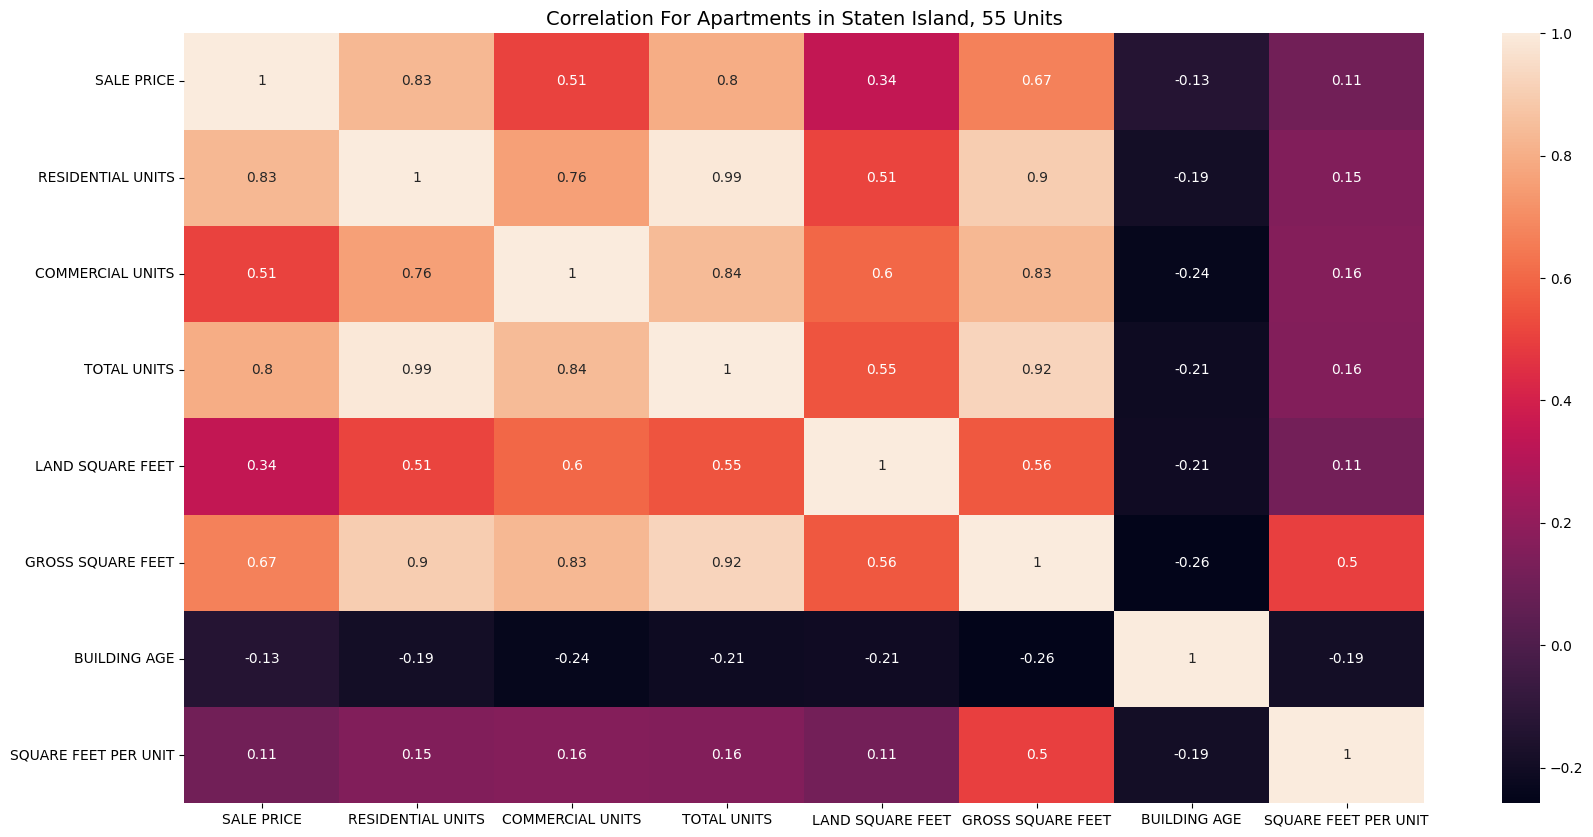

In [24]:
for borough in apart_df["BOROUGH"].unique():
    subset_df = apart_df[(apart_df["BOROUGH"] == borough)]
    subset_df = subset_df.select_dtypes(include='number')
    correlation_matrix = subset_df.corr()
    sum = subset_df["SALE PRICE"].count()
    sns.heatmap(correlation_matrix, annot=True)
    plt.title(f'Correlation For Apartments in {borough}, {sum} Units', fontsize=14)
    plt.show()

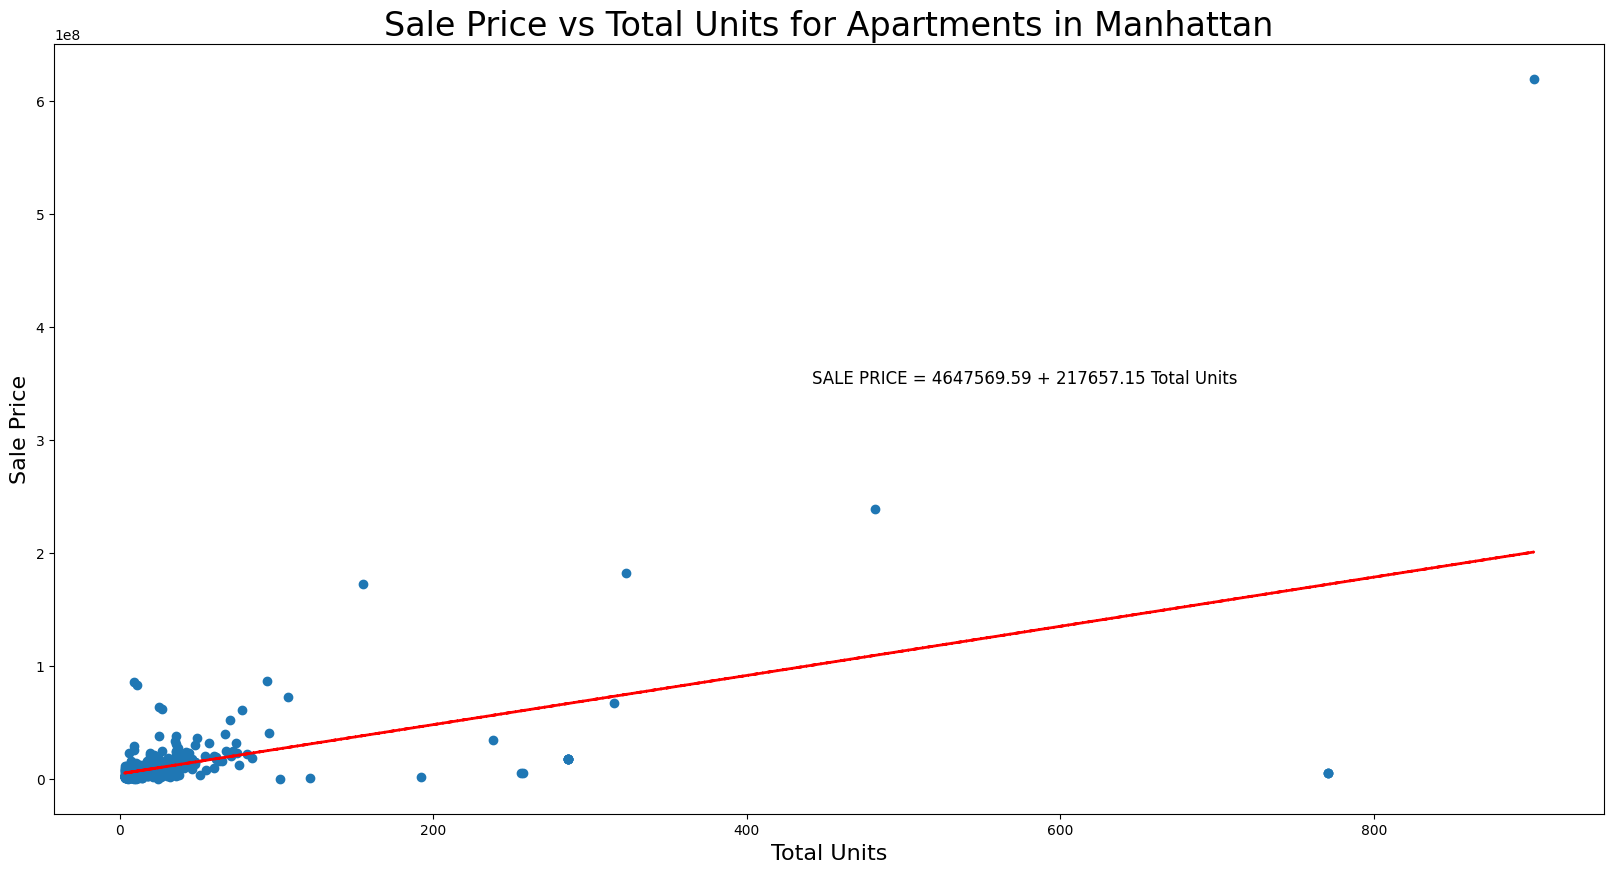

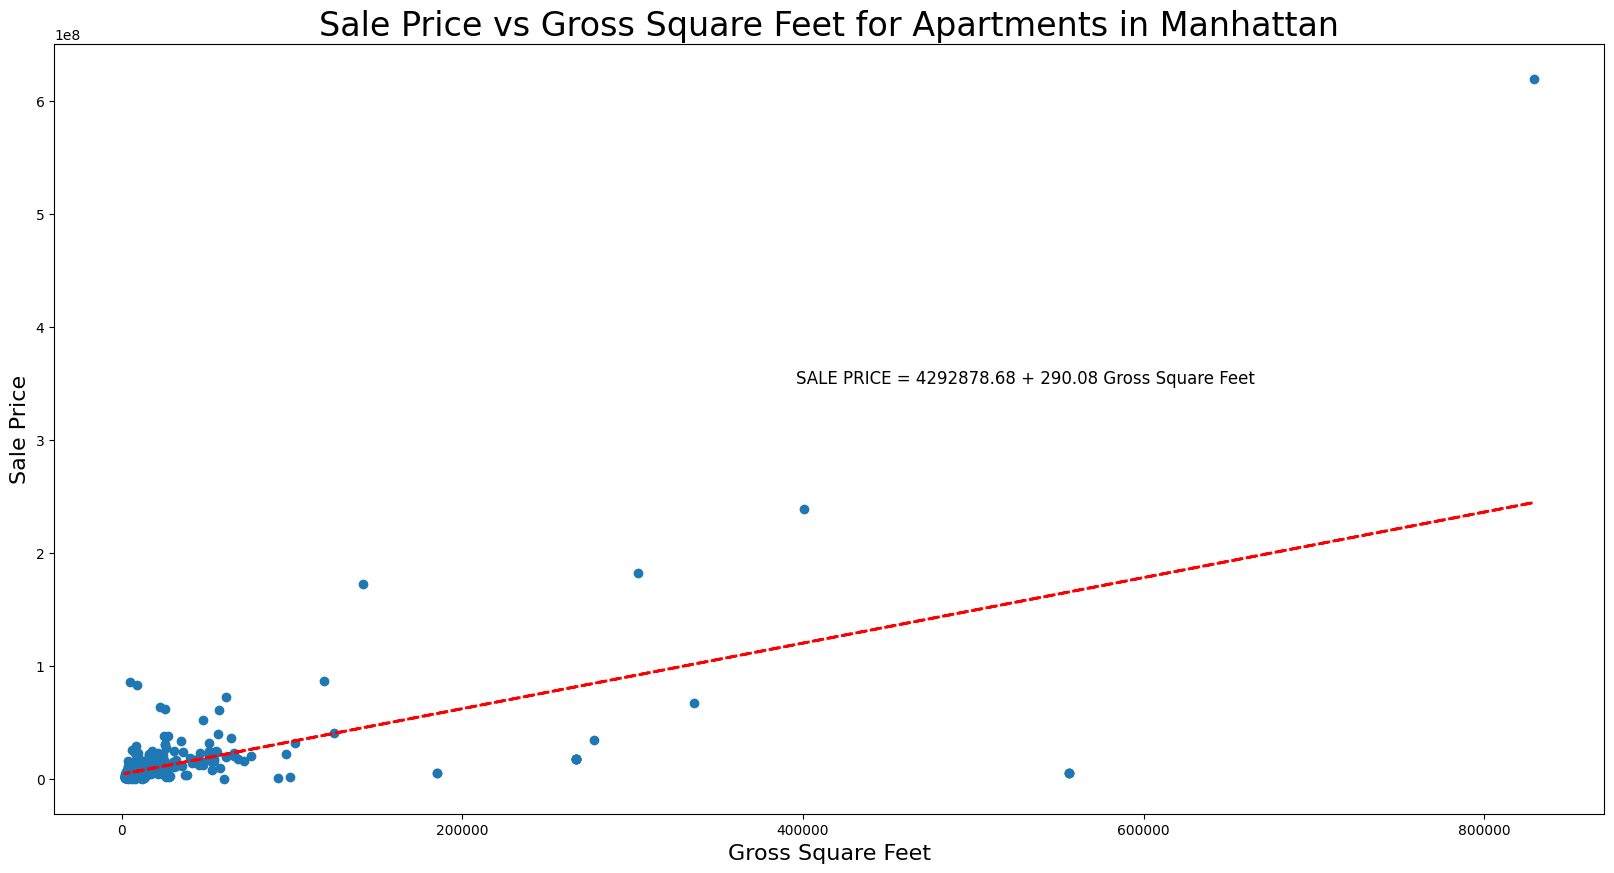

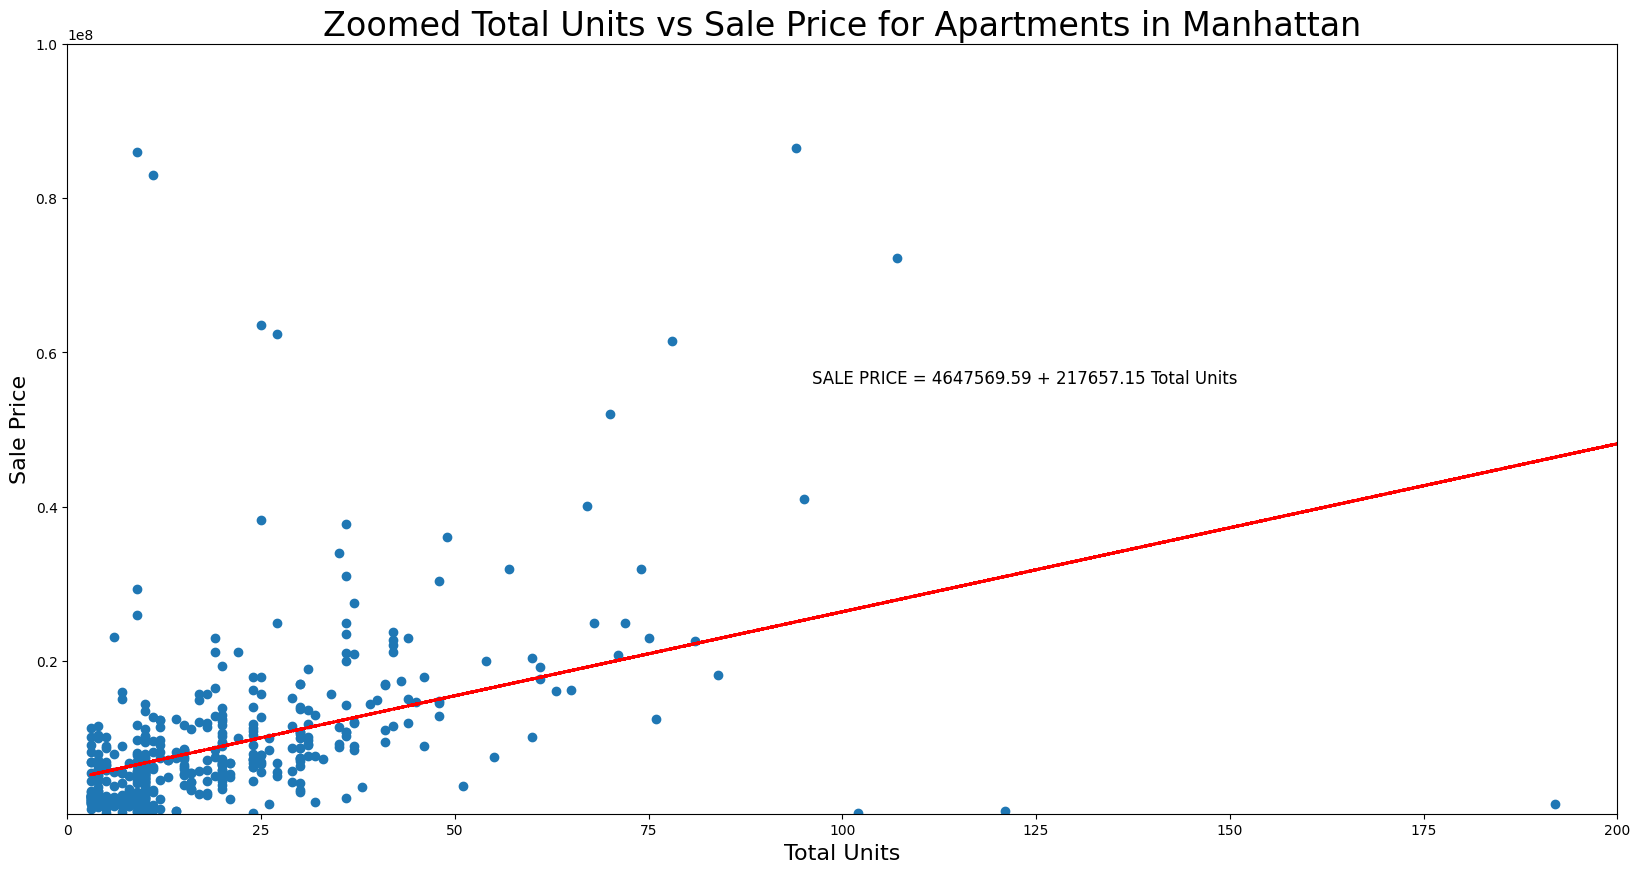

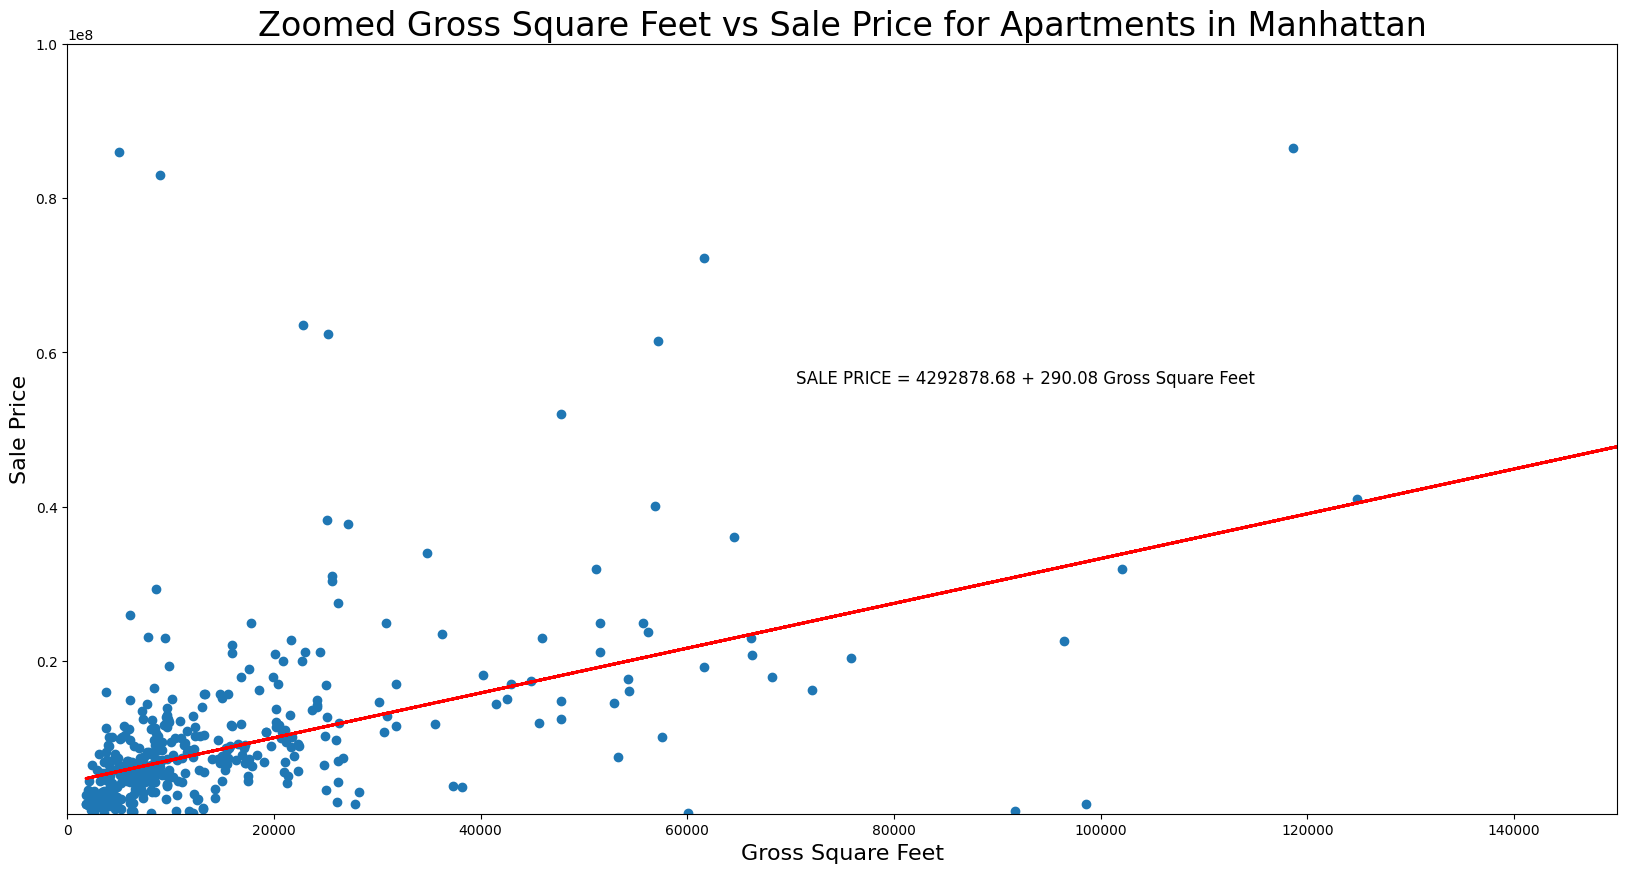

In [25]:
for i in range (2):
    for test in ["TOTAL UNITS", "GROSS SQUARE FEET"]:
        subset_df = apart_df[(apart_df["BOROUGH"] == "Manhattan")]
        subset_df = subset_df[["SALE PRICE", "TOTAL UNITS", "GROSS SQUARE FEET"]]
        plt.title(f'Sale Price vs {test.title()} for Apartments in Manhattan', size= 24)
        #find line of best fit
        x = subset_df[test]
        y = subset_df['SALE PRICE']
        a, b = np.polyfit(x, y, 1)
        #add points to plot
        plt.scatter(x, y)
        #add line of best fit to plot
        plt.plot(x, a*x+b, color='red', linestyle='--', linewidth=2)
        #add fitted regression equation to plot
        plt.text(0.5, 0.5, 'SALE PRICE = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + " " + test.title(),  horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes, size= 12)
        plt.ylabel("Sale Price", size= 16)
        plt.xlabel(test.title(), size= 16)
        if i == 1:
            plt.title(f'Zoomed {test.title()} vs Sale Price for Apartments in Manhattan', size= 24)
            if test == "TOTAL UNITS":
                plt.xlim ([0, 200])
                plt.ylim ([250000,100000000])
            else:
                plt.xlim ([0, 150000])
                plt.ylim ([250000,100000000])
        plt.show()



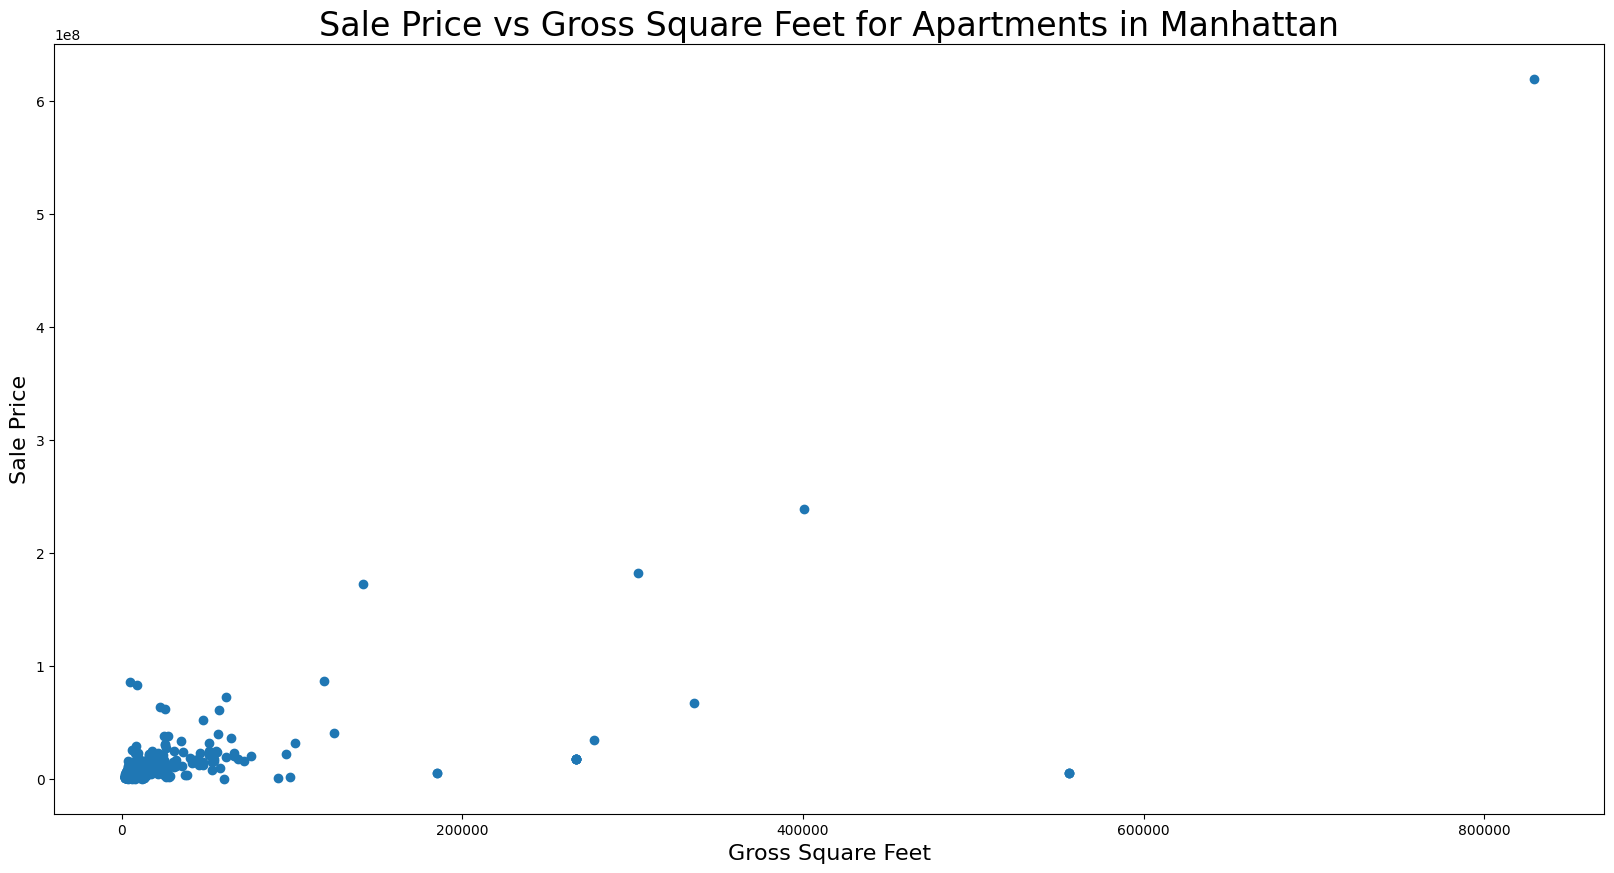

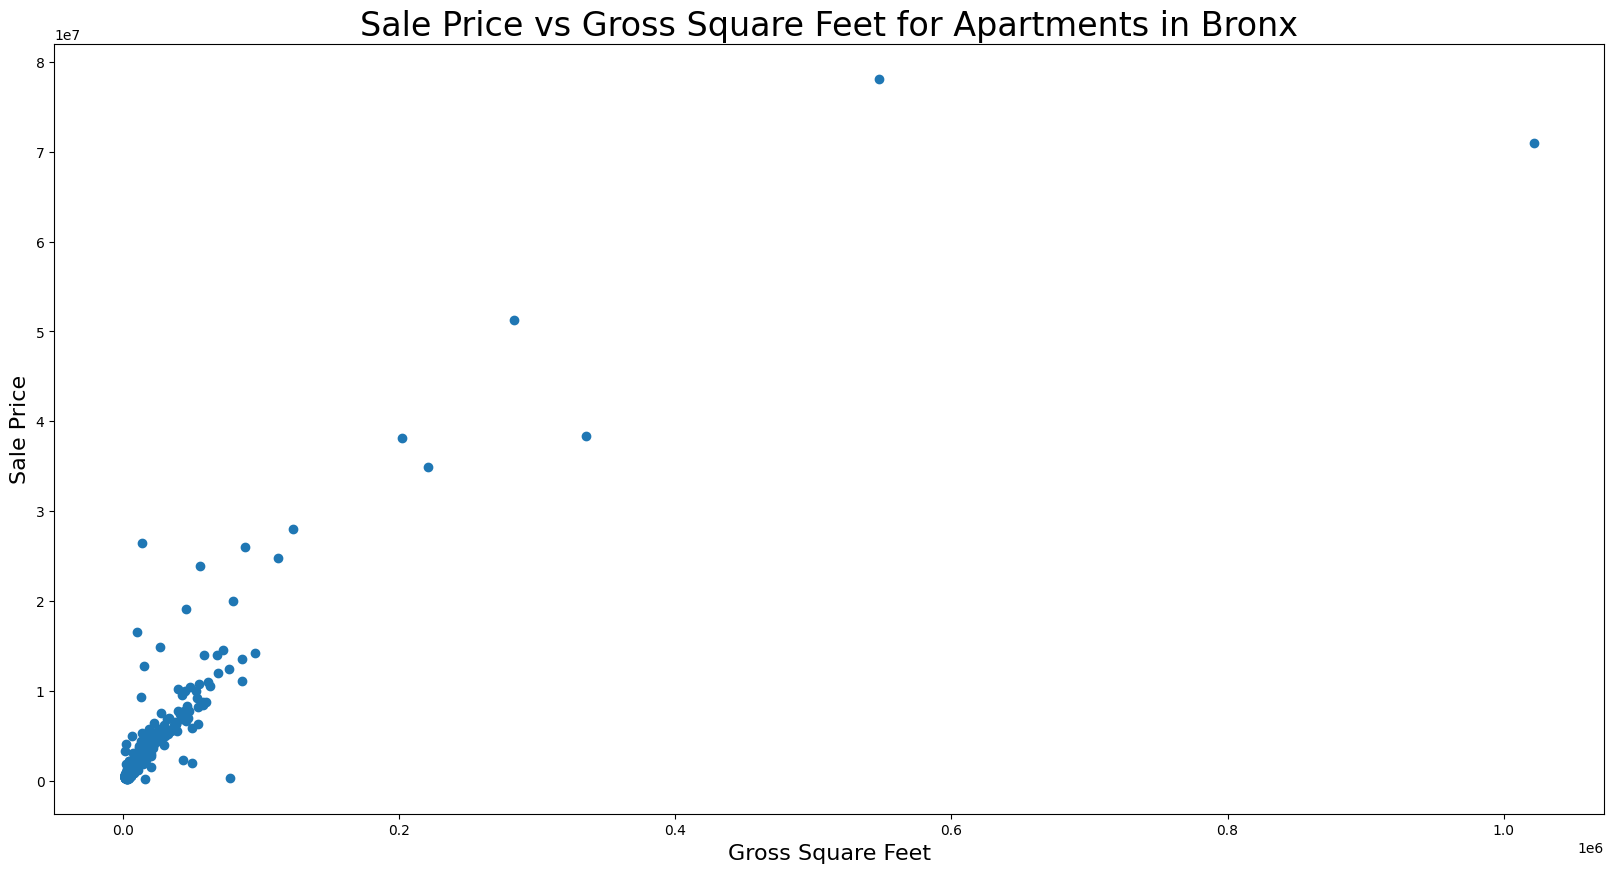

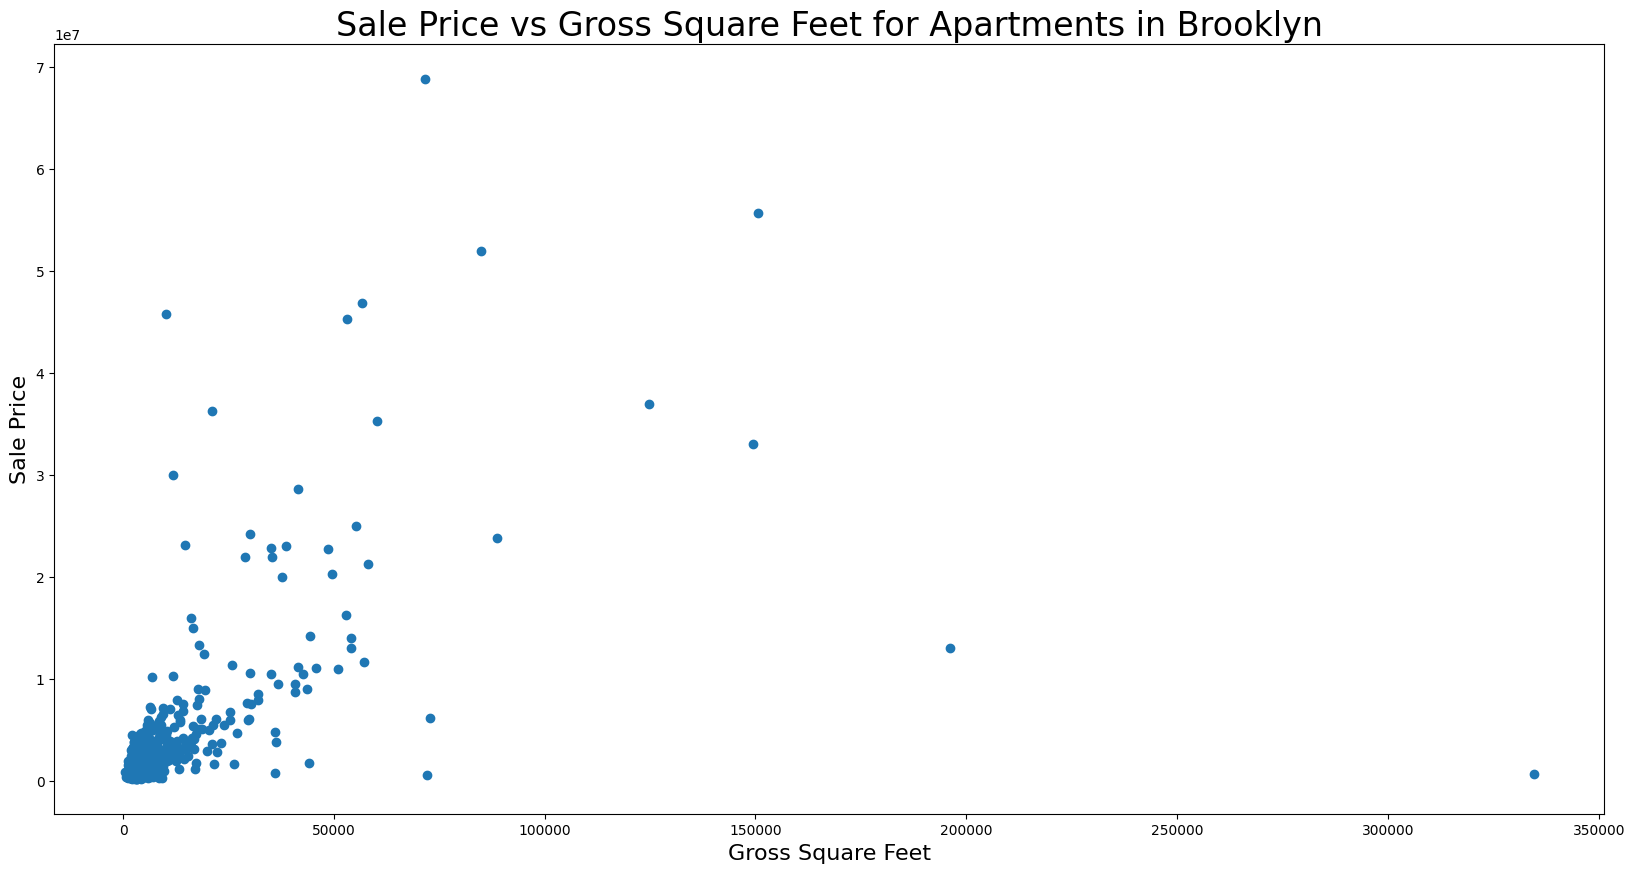

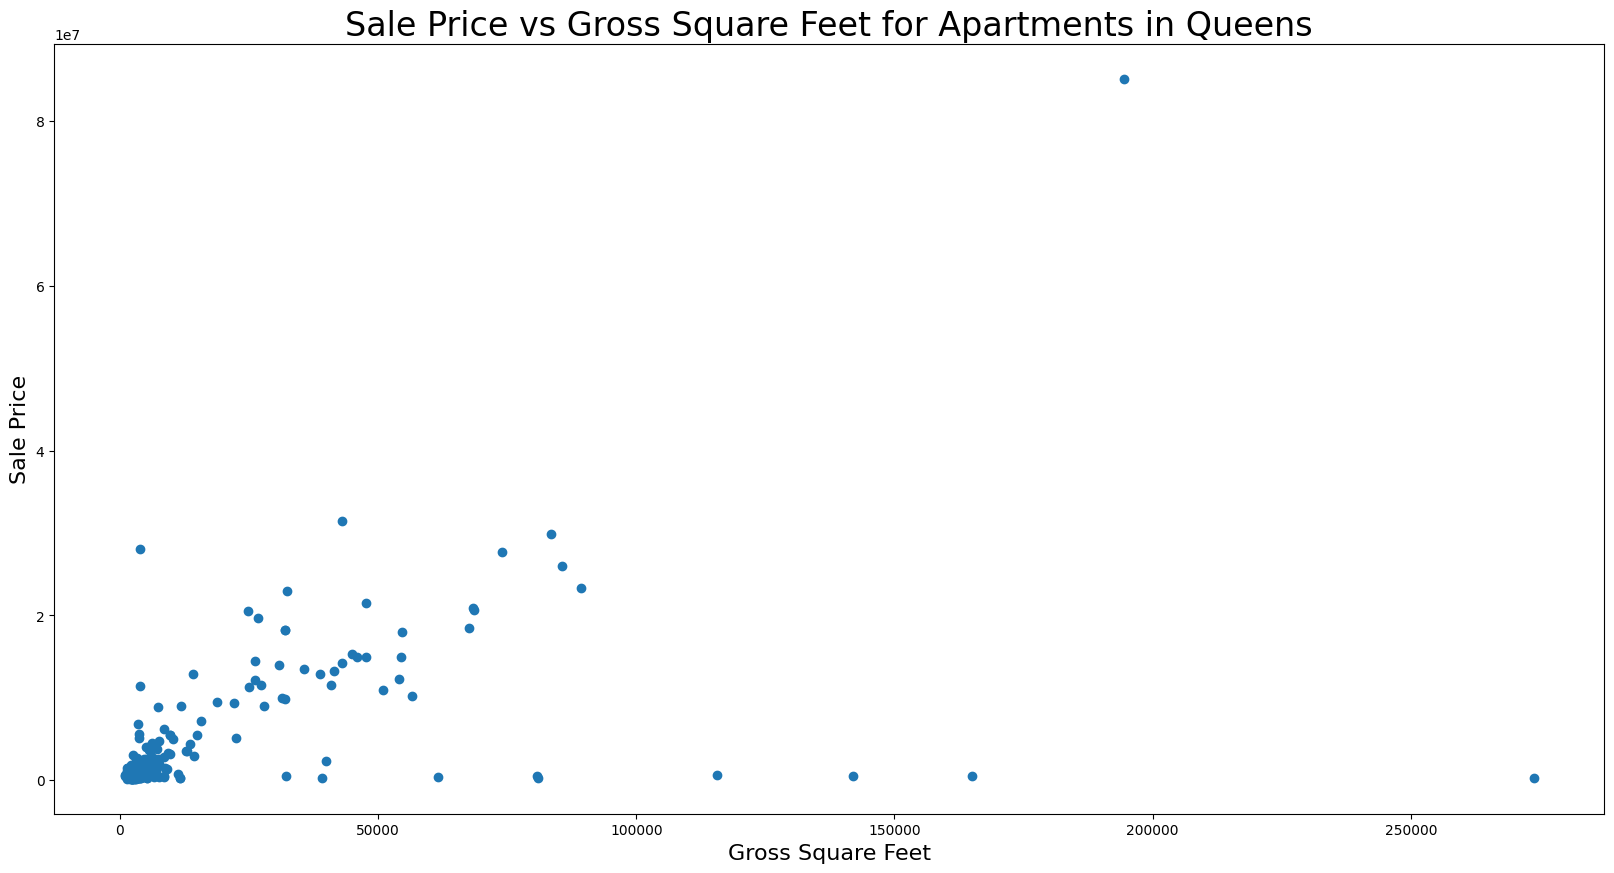

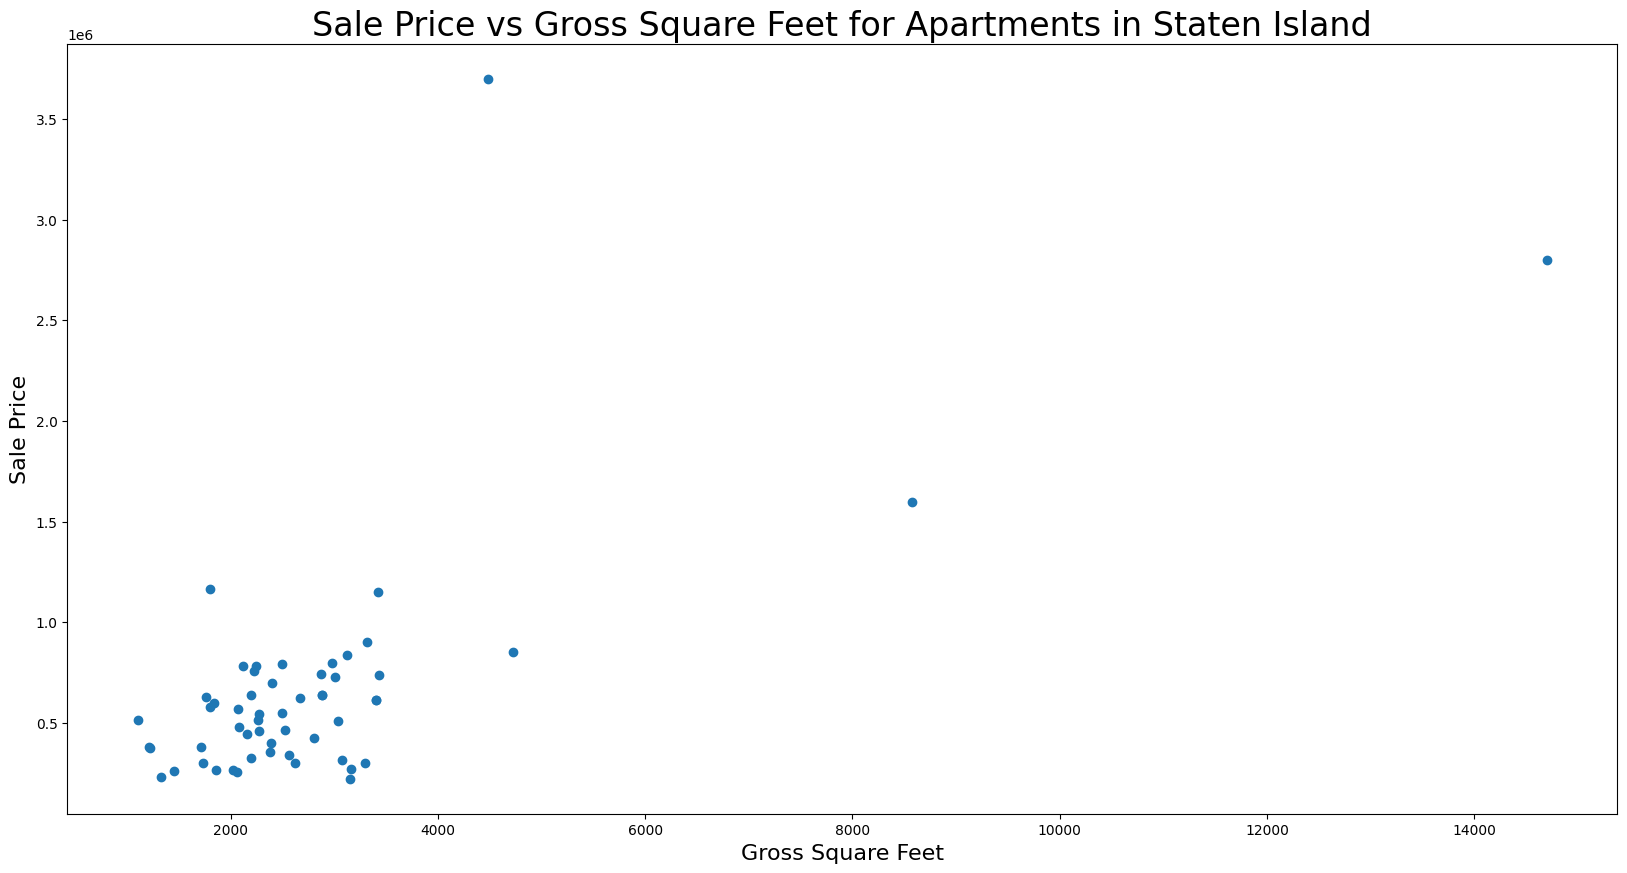

In [26]:
for borough in df["BOROUGH"].unique():
    subset_df = apart_df[(apart_df["BOROUGH"] == borough) & (apart_df["BUILDING GROUP"] == "Apartments")]
    subset_df = subset_df[["SALE PRICE", "TOTAL UNITS", "GROSS SQUARE FEET"]]
    plt.scatter(subset_df["GROSS SQUARE FEET"], subset_df["SALE PRICE"])
    plt.title(f'Sale Price vs Gross Square Feet for Apartments in {borough}', size= 24)
    plt.ylabel("Sale Price", size= 16)
    plt.xlabel("Gross Square Feet", size= 16)
    plt.show()

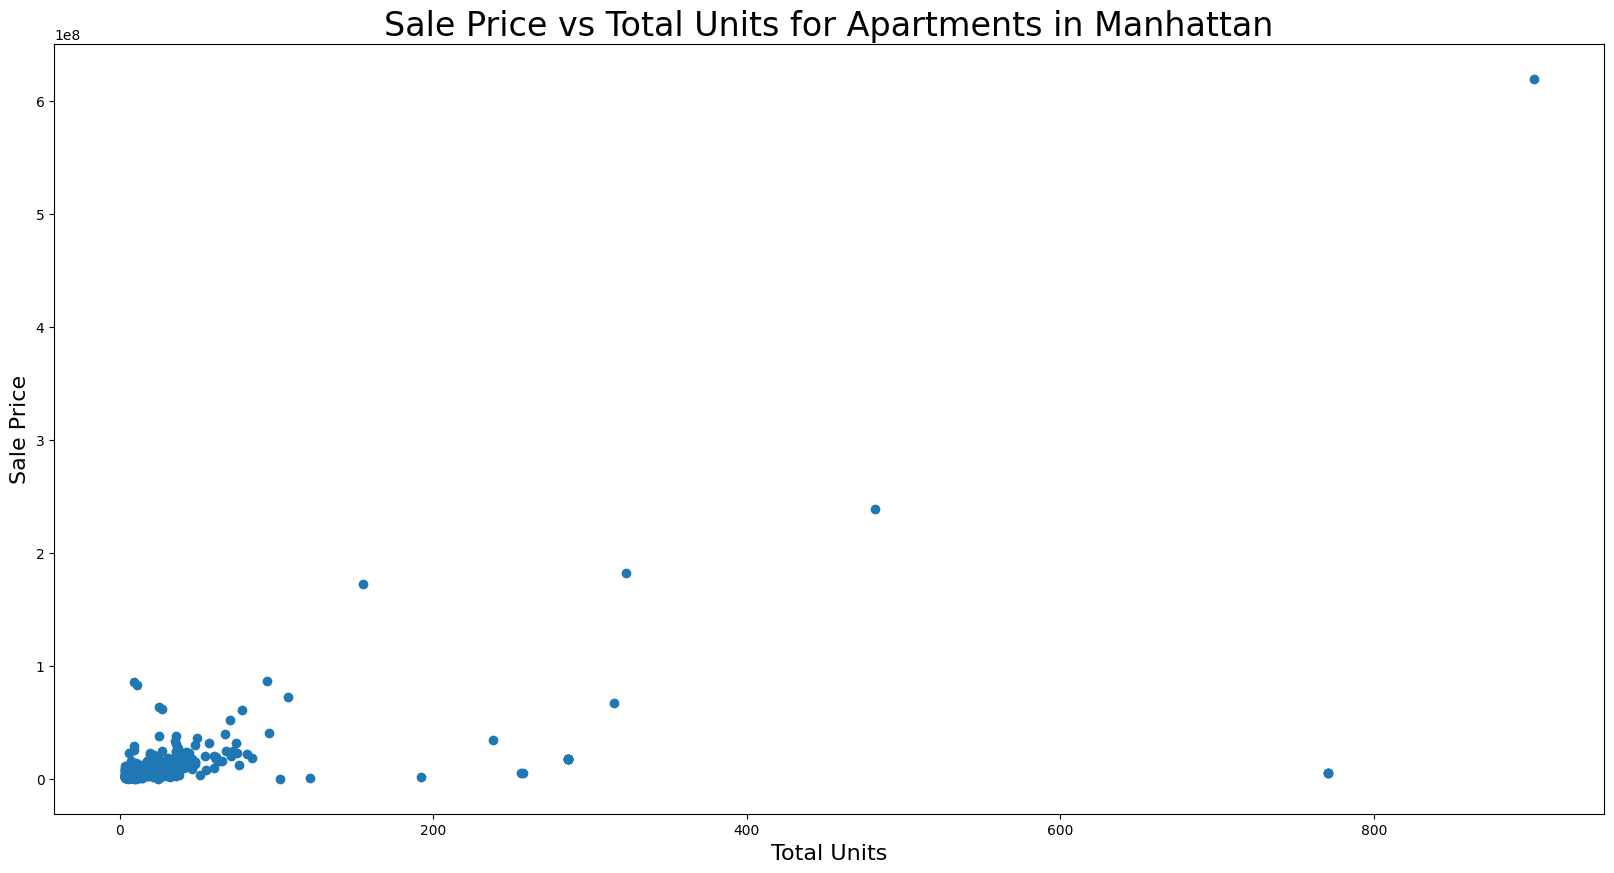

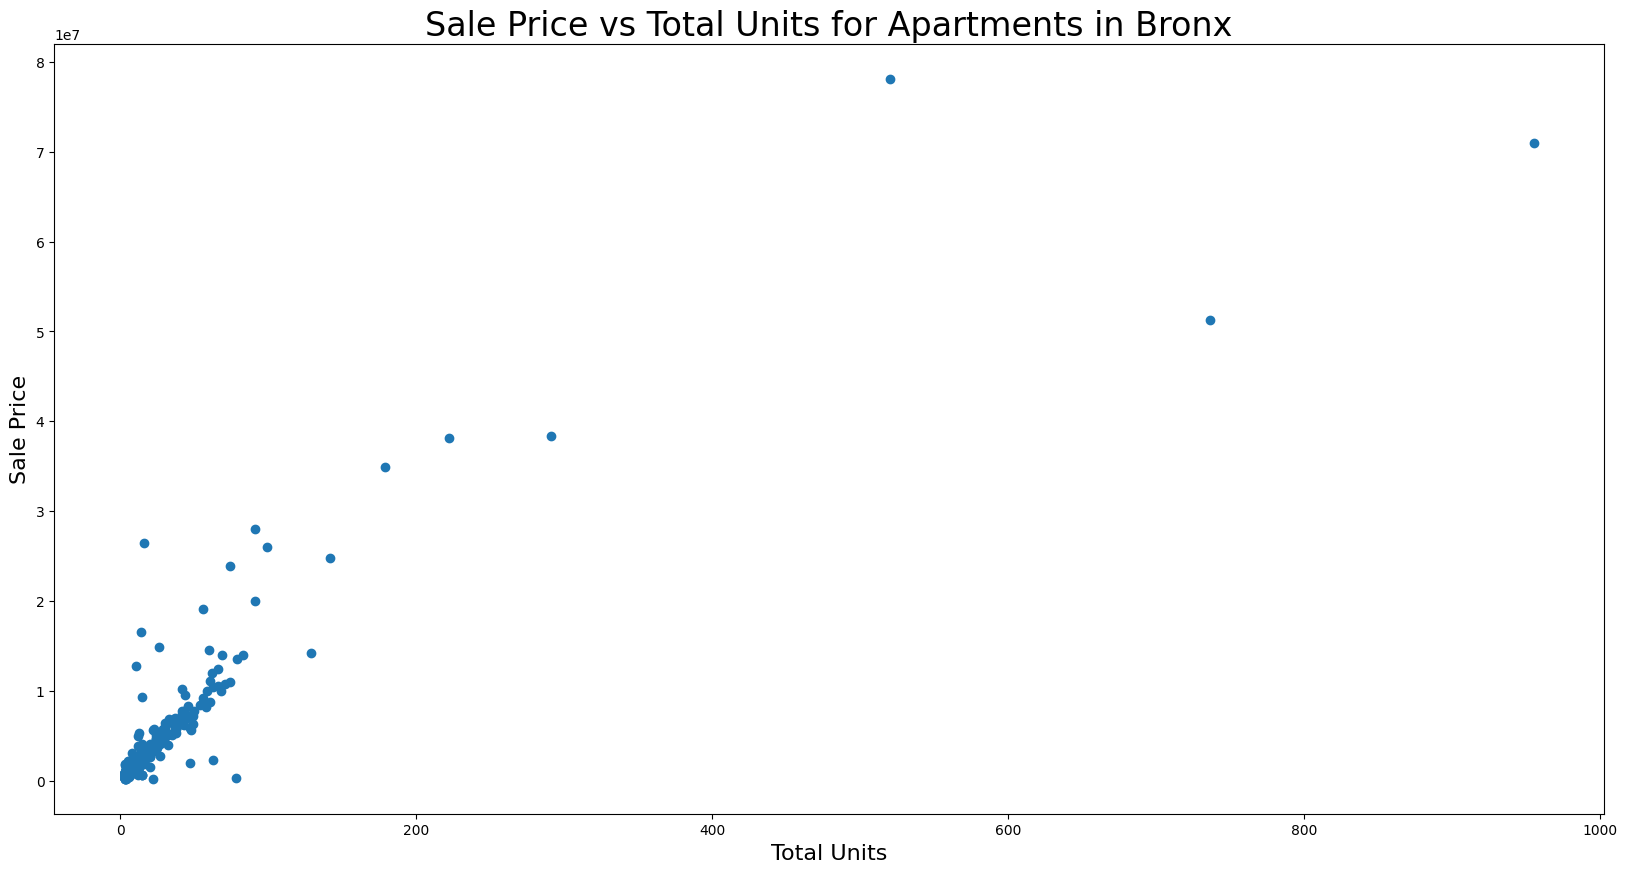

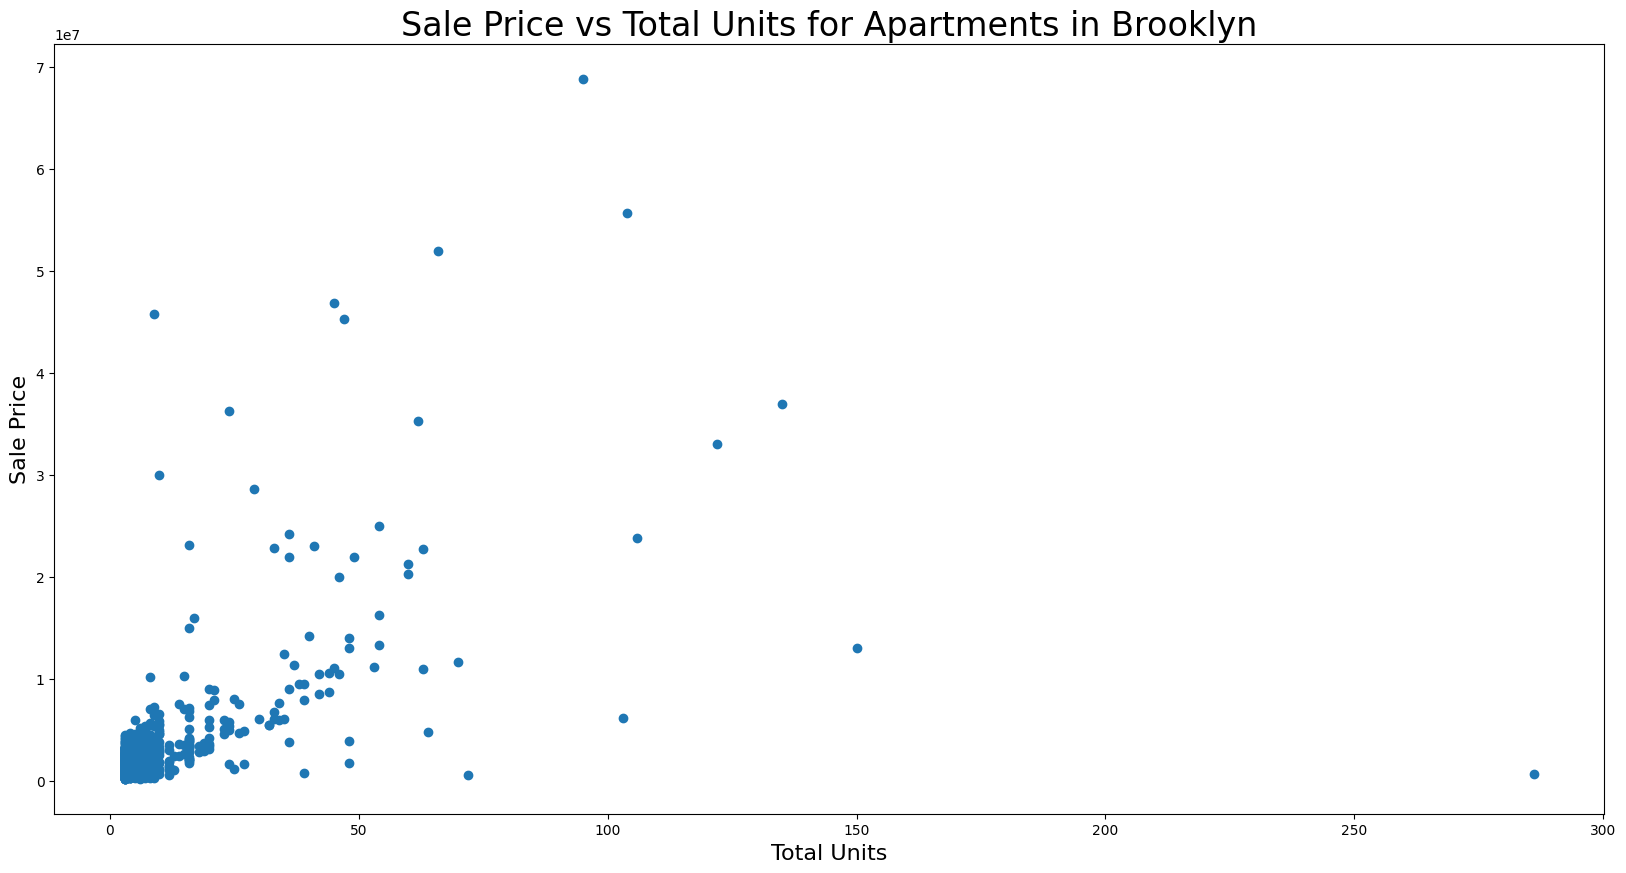

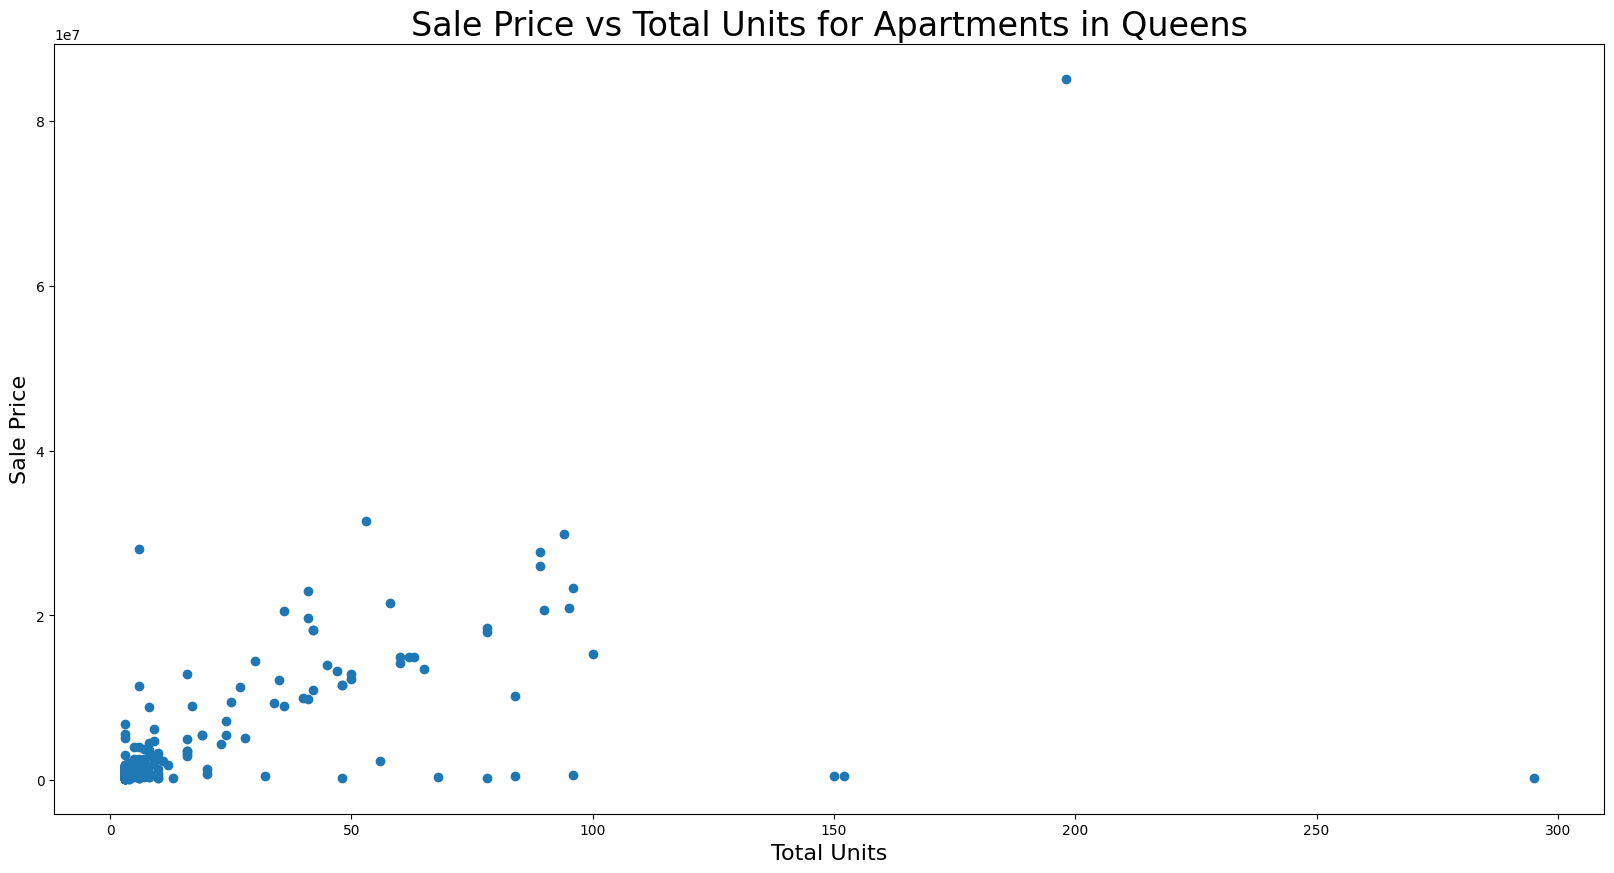

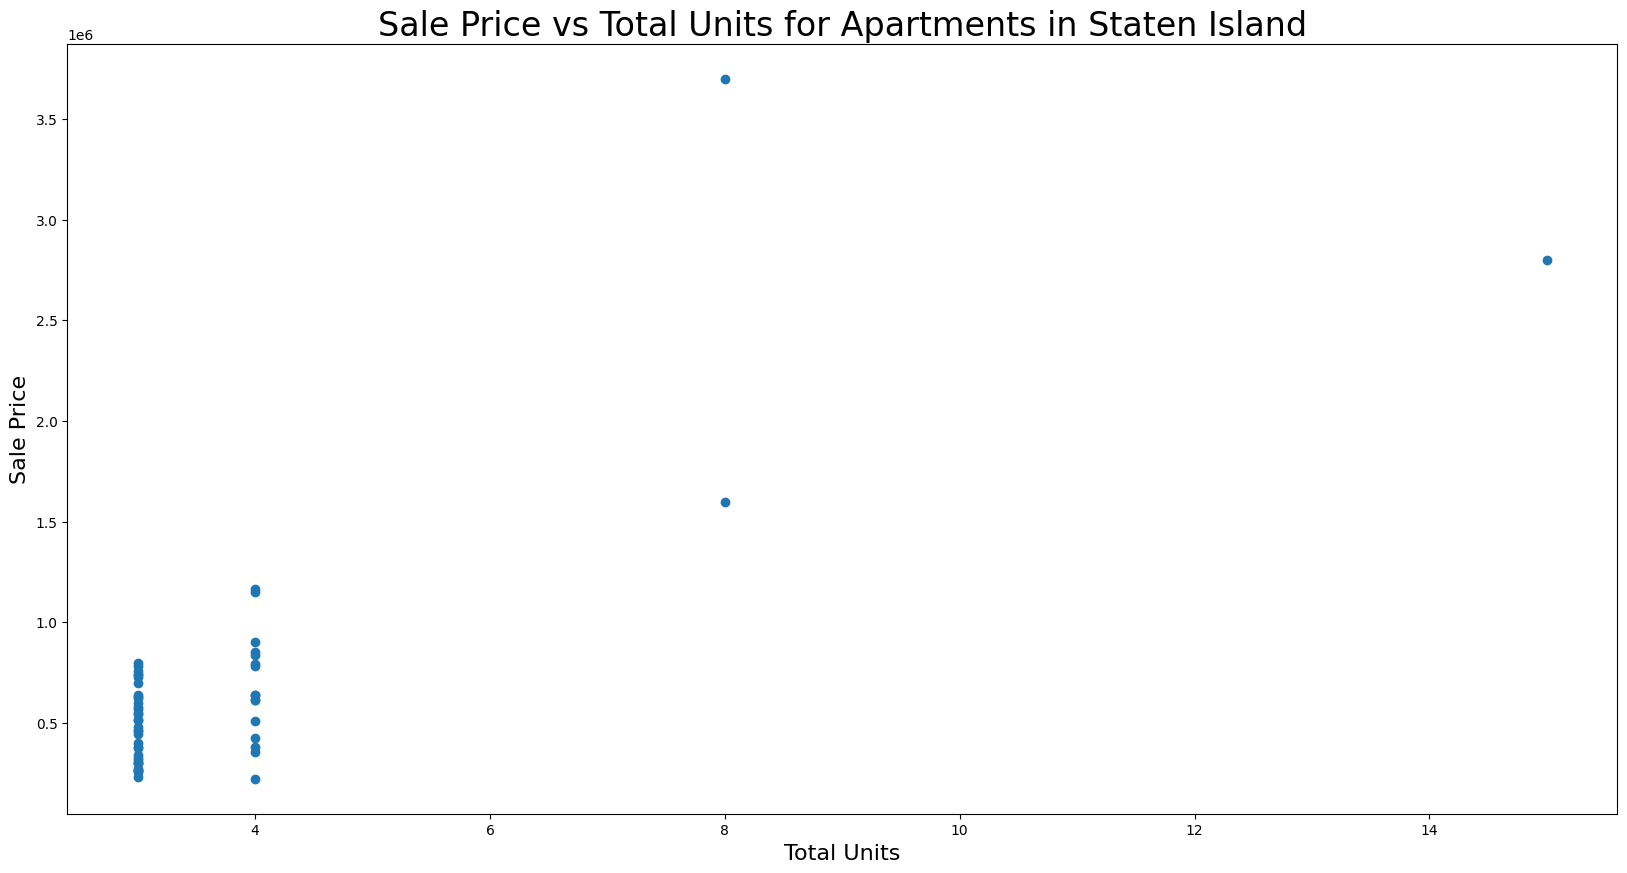

In [27]:
for borough in df["BOROUGH"].unique():
    subset_df = apart_df[(apart_df["BOROUGH"] == borough) & (apart_df["BUILDING GROUP"] == "Apartments")]
    subset_df = subset_df[["SALE PRICE", "TOTAL UNITS", "GROSS SQUARE FEET"]]
    plt.scatter(subset_df["TOTAL UNITS"], subset_df["SALE PRICE"])
    plt.title(f'Sale Price vs Total Units for Apartments in {borough}', size= 24)
    plt.ylabel("Sale Price", size= 16)
    plt.xlabel("Total Units", size= 16)
    plt.show()

In [28]:
apart_df.drop(apart_df[(apart_df["BOROUGH"] == "Queens") & (apart_df["GROSS SQUARE FEET"] > 100000)  & (apart_df["SALE PRICE"] < 1000000)].index, inplace=True)

/var/folders/3s/y7v95n61797f2hfj0h9x9rbc0000gn/T/ipykernel_49772/4164173413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apart_df.drop(apart_df[(apart_df["BOROUGH"] == "Queens") & (apart_df["GROSS SQUARE FEET"] > 100000)  & (apart_df["SALE PRICE"] < 1000000)].index, inplace=True)


In [29]:
apart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4023 entries, 0 to 69147
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   SALE PRICE                 4023 non-null   float64       
 1   BOROUGH                    4023 non-null   object        
 2   NEIGHBORHOOD               4023 non-null   object        
 3   BUILDING CLASS CATEGORY    4023 non-null   object        
 4   BUILDING CLASS AT PRESENT  4023 non-null   object        
 5   ADDRESS                    4023 non-null   object        
 6   ZIP CODE                   4023 non-null   object        
 7   RESIDENTIAL UNITS          4023 non-null   int64         
 8   COMMERCIAL UNITS           4023 non-null   int64         
 9   TOTAL UNITS                4023 non-null   int64         
 10  LAND SQUARE FEET           4023 non-null   int64         
 11  GROSS SQUARE FEET          4023 non-null   int64         
 12  SALE DATE 

In [30]:
apart_df

,SALE PRICE,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE DATE,BUILDING AGE,BUILDING GROUP,SQUARE FEET PER UNIT
0,6625000.0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C2,153 AVENUE B,10009,5,0,5,1633,6440,2017-07-19,117,Apartments,1288.000000
1,3936272.0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C4,154 EAST 7TH STREET,10009,10,0,10,2272,6794,2016-09-23,103,Apartments,679.400000
2,8000000.0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C2,301 EAST 10TH STREET,10009,6,0,6,2369,4615,2016-11-17,116,Apartments,769.166667
3,3192840.0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C4,210 AVENUE B,10009,8,0,8,1750,4226,2016-09-23,96,Apartments,528.250000
4,16232000.0,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,D9,629 EAST 5TH STREET,10009,24,0,24,4489,18523,2016-11-07,96,Apartments,771.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69131,785000.0,Staten Island,WEST NEW BRIGHTON,03 THREE FAMILY DWELLINGS,C0,394 BARD AVENUE,10310,3,0,3,7200,2244,2017-07-21,77,Apartments,748.000000
69132,515000.0,Staten Island,WEST NEW BRIGHTON,03 THREE FAMILY DWELLINGS,C0,24 DE GROOT PLACE,10310,3,0,3,5500,2266,2017-03-29,116,Apartments,755.333333
69133,300000.0,Staten Island,WEST NEW BRIGHTON,03 THREE FAMILY DWELLINGS,C0,666 CARY AVENUE,10310,3,0,3,2775,3300,2016-12-16,66,Apartments,1100.000000
69146,1150000.0,Staten Island,WEST NEW BRIGHTON,07 RENTALS - WALKUP APARTMENTS,C3,468 HOYT AVENUE,10301,4,0,4,5250,3424,2016-09-14,96,Apartments,856.000000


In [31]:
apart_df ["FULL ADDRESS"] = apart_df['ADDRESS'] + ', '+ apart_df['NEIGHBORHOOD'] + ', '+ apart_df['BOROUGH'] + ', New York, '+ apart_df['ZIP CODE'].astype(str)

/var/folders/3s/y7v95n61797f2hfj0h9x9rbc0000gn/T/ipykernel_49772/536541763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apart_df ["FULL ADDRESS"] = apart_df['ADDRESS'] + ', '+ apart_df['NEIGHBORHOOD'] + ', '+ apart_df['BOROUGH'] + ', New York, '+ apart_df['ZIP CODE'].astype(str)


In [32]:
def geocode(add):
    g = gmaps_key.geocode(add)
    lat = g[0]["geometry"]["location"]["lat"]
    lng = g[0]["geometry"]["location"]["lng"]
    return (lat, lng)

apart_df['GEOCODED'] = apart_df ["FULL ADDRESS"].apply(geocode)

/var/folders/3s/y7v95n61797f2hfj0h9x9rbc0000gn/T/ipykernel_49772/1390581128.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apart_df['GEOCODED'] = apart_df ["FULL ADDRESS"].apply(geocode)


In [33]:
apart_df =apart_df.drop_duplicates(subset=['GEOCODED'])

In [58]:
apart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SALE PRICE                 3846 non-null   int64  
 1   BOROUGH                    3846 non-null   object 
 2   NEIGHBORHOOD               3846 non-null   object 
 3   BUILDING CLASS CATEGORY    3846 non-null   object 
 4   BUILDING CLASS AT PRESENT  3846 non-null   object 
 5   ADDRESS                    3846 non-null   object 
 6   ZIP CODE                   3846 non-null   int64  
 7   RESIDENTIAL UNITS          3846 non-null   int64  
 8   COMMERCIAL UNITS           3846 non-null   int64  
 9   TOTAL UNITS                3846 non-null   int64  
 10  LAND SQUARE FEET           3846 non-null   int64  
 11  GROSS SQUARE FEET          3846 non-null   int64  
 12  BUILDING AGE               3846 non-null   int64  
 13  BUILDING GROUP             3846 non-null   objec

In [59]:
apart_df['const'] = 1

for borough in apart_df["BOROUGH"].unique():
    subset_df = apart_df[apart_df["BOROUGH"] == borough].copy()
    
    # Define the independent variables (X)
    X = subset_df[['const',  'GROSS SQUARE FEET', 'TOTAL UNITS']]
    
    # Define the dependent variable (Y)
    Y = subset_df['SALE PRICE']
    
    # Fit the regression model
    model = sm.OLS(Y, X).fit()
    
    # Print the regression results
    print(f'Regression for Apartments in {borough}')
    print(model.summary())
    print('\n\n')

Regression for Apartments in Bronx
                            OLS Regression Results                            
Dep. Variable:             SALE PRICE   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1447.
Date:                Thu, 07 Dec 2023   Prob (F-statistic):          2.31e-258
Time:                        14:57:30   Log-Likelihood:                -12205.
No. Observations:                 754   AIC:                         2.442e+04
Df Residuals:                     751   BIC:                         2.443e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
con